# Предсказание риска сердечных приступов

Ссылка на проект в GitHub - https://github.com/MaratKadyrov/heart_attack

**Цель исследования:**
- Создать модель для предсказания риска сердечных приступов

**Ход исследования:**
- Импорт данных;
- Предобработка данных;
- Исследование датасета;
- Обучение модели.

**Описание признаков**
| Признак | Описание |
|:--:|:--:|
| **Age** | Возраст (количественный, отмасштабирован) |
| **Cholesterol** | Холестерин в крови (количественный, отмасштабирован) |
| **Heart rate** | Частота сердечных сокращений (количественный, отмасштабирован) |
| **Diabetes** | Наличие диабета (категориальный) |
| **Family History** | История семьи (категориальный) |
| **Smoking** | Курит ли пациент (категориальный) |
| **Obesity** | Ожирение (категориальный) |
| **Alcohol Consumption** | Употребляет ли пациент алкоголь (категориальный) |
| **Exercise Hours Per Week** | Физическая активность, часов в неделю (количественный, отмасштабирован) |
| **Diet** | Диета (категориальный) |
| **Previous Heart Problems** | Наличие проблем с сердец в прошлом (категориальный) |
| **Medication Use** | Использует ли пациент лекарства (категориальный) |
| **Stress Level** | Уровень стресса (количественный дискретный) |
| **Sedentary Hours Per Day** | Количество часов в сидячем положении (количественный, отмасштабирован) |
| **Income** | Доход (количественный, отмасштабирован) |
| **BMI** | Индекс массы тела (количественный, отмасштабирован) |
| **Triglycerides** | Триглицериды (количественный, отмасштабирован) | 
| **Physical Activity Days Per Week** | Количество дней активности в неделю (количественный дискретный) |
| **Sleep Hours Per Day** | Количество часов сна в день (количественный дискретный) |
| **Heart Attack Risk (Binary)** | Риск сердечного приступа (категориальный, **целевой признак**) |
| **Blood sugar** | Сахар в крови (количественный, отмасштабирован) | 
| **CK-MB** | Креатинкиназа МВ (количественный, отмасштабирован) | 
| **Troponin** | Тропонин (количественный, отмасштабирован) | 
| **Gender** | Пол (категориальный) |
| **Systolic blood pressure** | Систолическое артериальное давление (количественный, отмасштабирован) |
| **Diastolic blood pressure** | Диастолическое артериальное давление (количественный, отмасштабирован) |
| **id** | Уникальный идентификатор пациента |

## Импорт библиотек

In [979]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   LabelEncoder)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

from optuna import distributions
from optuna.integration import OptunaSearchCV

from warnings import simplefilter
simplefilter(action='ignore')

pd.set_option('display.float_format', '{:,.2f}'.format)
RANDOM_STATE = 42
MODEL_NAME_PKL = 'models/model_heart_attack.pkl'

## Загрузка данных

In [980]:
pth_train = 'datasets/heart_train.csv'
pth_test = 'datasets/heart_test.csv'

In [981]:
if os.path.exists(pth_train):
    train_df = pd.read_csv(pth_train)
else:
    print('Упс, что-то пошло не так!')
                                         
train_df.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.36,0.73,0.07,1.00,1.00,1.00,1.00,1.00,0.54,...,3.00,0.33,0.00,0.23,0.05,0.04,Male,0.21,0.71,2664
1,1,0.20,0.33,0.05,1.00,1.00,0.00,0.00,1.00,0.07,...,3.00,0.83,0.00,0.15,0.02,0.00,Female,0.41,0.57,9287
2,2,0.61,0.86,0.06,1.00,0.00,1.00,1.00,1.00,0.94,...,2.00,1.00,0.00,0.23,0.05,0.04,Female,0.24,0.22,5379
3,3,0.73,0.01,0.05,0.00,0.00,1.00,0.00,1.00,0.70,...,0.00,0.33,1.00,0.23,0.05,0.04,Female,0.35,0.27,8222
4,4,0.78,0.76,0.02,0.00,0.00,1.00,0.00,1.00,0.41,...,5.00,1.00,1.00,0.23,0.05,0.04,Male,0.62,0.44,4047


In [982]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [983]:
if os.path.exists(pth1):
    test_df = pd.read_csv(pth_test)
else:
    print('Упс, что-то пошло не так!')
                                         
train_df.head()

Упс, что-то пошло не так!


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.36,0.73,0.07,1.00,1.00,1.00,1.00,1.00,0.54,...,3.00,0.33,0.00,0.23,0.05,0.04,Male,0.21,0.71,2664
1,1,0.20,0.33,0.05,1.00,1.00,0.00,0.00,1.00,0.07,...,3.00,0.83,0.00,0.15,0.02,0.00,Female,0.41,0.57,9287
2,2,0.61,0.86,0.06,1.00,0.00,1.00,1.00,1.00,0.94,...,2.00,1.00,0.00,0.23,0.05,0.04,Female,0.24,0.22,5379
3,3,0.73,0.01,0.05,0.00,0.00,1.00,0.00,1.00,0.70,...,0.00,0.33,1.00,0.23,0.05,0.04,Female,0.35,0.27,8222
4,4,0.78,0.76,0.02,0.00,0.00,1.00,0.00,1.00,0.41,...,5.00,1.00,1.00,0.23,0.05,0.04,Male,0.62,0.44,4047


In [984]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level          

In [985]:
# Составим списки для количественных и категориальных признаков
numerical_features = [
    'Age',
    'Cholesterol',
    'Heart rate',
    'Exercise Hours Per Week',
    'Stress Level', # дискретный
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    'Physical Activity Days Per Week',  # дискретный
    'Sleep Hours Per Day',  # дискретный
    'Blood sugar',
    'CK-MB',
    'Troponin',
    'Systolic blood pressure',
    'Diastolic blood pressure'
]

categorical_features = [
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Diet',
    'Previous Heart Problems',
    'Medication Use',
    'Heart Attack Risk (Binary)',
    'Gender'
]

Вывод
- В датафрейме 8685 строк;
- Есть пропуски;

## Предобработка данных

### Удаление признака "Unnamed: 0"

In [986]:
if 'Unnamed: 0' in train_df.columns:
    train_df.drop('Unnamed: 0', axis=1, inplace=True)
    
if 'Unnamed: 0' in test_df.columns:
    test_df.drop('Unnamed: 0', axis=1, inplace=True)
    
print(train_df.columns)
print(test_df.columns)

Index(['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week',
       'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day',
       'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin',
       'Gender', 'Systolic blood pressure', 'Diastolic blood pressure', 'id'],
      dtype='object')
Index(['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week',
       'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Blood sugar',
       'CK-MB', 'Troponin', 'Gender', 'Systolic blood pressure',
       'Diastolic blood 

### Обработка дубликатов

#### Проверка явных дубликатов

In [987]:
train_df.duplicated().sum()

0

#### Проверка неявных дубликатов

In [988]:
# Поиск дубликатов по ID
train_df['id'].duplicated().sum()

0

In [989]:
# Поиск дубликатов по всем признакам, за исключение признака ID
train_df.drop('id', axis=1).duplicated().sum()

0

### Обработка пропусков

In [990]:
missing_values = train_df.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Physical Activity Days Per Week    243
dtype: int64

### Обработка выбросов

In [991]:
def statistics_for_num(feature):
    # Расчет количество выбросов
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    
    print(f"Признак - {feature}")
    print(f"Количество выбросов: {len(outliers)}")
    print()

In [992]:
for feature in numerical_features:
    statistics_for_num(feature)

Признак - Age
Количество выбросов: 0

Признак - Cholesterol
Количество выбросов: 0

Признак - Heart rate
Количество выбросов: 2

Признак - Exercise Hours Per Week
Количество выбросов: 0

Признак - Stress Level
Количество выбросов: 0

Признак - Sedentary Hours Per Day
Количество выбросов: 0

Признак - Income
Количество выбросов: 0

Признак - BMI
Количество выбросов: 0

Признак - Triglycerides
Количество выбросов: 0

Признак - Physical Activity Days Per Week
Количество выбросов: 0

Признак - Sleep Hours Per Day
Количество выбросов: 0

Признак - Blood sugar
Количество выбросов: 2134

Признак - CK-MB
Количество выбросов: 2134

Признак - Troponin
Количество выбросов: 2134

Признак - Systolic blood pressure
Количество выбросов: 0

Признак - Diastolic blood pressure
Количество выбросов: 0



In [993]:
# Выявим выбросы в признаке 'Heart rate'
train_df[train_df['Heart rate'] == 1]

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
1377,0.63,0.50,1.00,NaN,NaN,NaN,NaN,NaN,0.50,3,...,NaN,0.50,0.00,0.20,0.01,0.00,0.0,0.49,0.62,9547
2712,0.20,0.50,1.00,NaN,NaN,NaN,NaN,NaN,0.50,3,...,NaN,0.50,0.00,0.09,0.01,0.00,0.0,0.49,0.62,9611


In [994]:
# Удалим выбросы в признаке 'Heart rate'
train_df = train_df[train_df['Heart rate'] != 1]

In [995]:
statistics_for_num('Heart rate')

Признак - Heart rate
Количество выбросов: 0



Вывод по подразделу "Обработка выбросов":
- Выполнено удаление выбросов признаке **"Heart rate"**
- Для остальных признаков, количество выбросов составляет значительную часть датасеты, и их удаление невозможно.

### Аномалии в признаке "Gender"

In [996]:
# Отобразим количество по категориям
train_df['Gender'].value_counts()

Gender
Male      5882
Female    2560
1.0        156
0.0         85
Name: count, dtype: int64

In [997]:
test_df['Gender'].value_counts()

Gender
Male      672
Female    294
Name: count, dtype: int64

In [998]:
train_df['Gender'] = train_df['Gender'].replace('1.0', 'Male')
train_df['Gender'] = train_df['Gender'].replace('0.0', 'Female')
test_df['Gender'] = test_df['Gender'].replace('1.0', 'Male')
test_df['Gender'] = test_df['Gender'].replace('0.0', 'Female')

In [999]:
# Проверим замену
train_df['Gender'].value_counts()

Gender
Male      6038
Female    2645
Name: count, dtype: int64

In [1000]:
test_df['Gender'].value_counts()

Gender
Male      672
Female    294
Name: count, dtype: int64

Вывод по подразделу 'Аномалии в признаке "Gender"':
- Часть данных закодирована
- Аналогичная проблема присутсвует в тестовом датасете
- Выполнено исправление аномалий

Вывод по разделу **"Предобработка данных"**:
- Удален признак **"Unnamed: 0"** как неинформативный;
- Дубликаты отсутствуют;
- Выполнено удаление выбросов признаке **"Heart rate"**;
- Часть данных в признаке **"Gender"** закодирована. Аналогичная проблема присутсвует в тестовом датасете. Эта проблема будет исправлена в пайплайне

## Исследовательский анализ

In [1001]:
def visualize_categorical_feature(df, plot=None, feature = None, hue = None, title = None, xlabel = None, ylabel = None):
    """
    Визуализирует и анализирует категориальные признаки.
    
    :param df: DataFrame с данными
    :param feature: категориальных признак для анализа
    """
    counts = df[feature].value_counts()

    # График распределения
    plt.figure(figsize=(6, 6))
    
    if plot == None:
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140);
    else:
        sns.countplot(data=df,
                      x=feature,
                      hue=hue,
                      palette="summer",
                     order=df[feature].value_counts().index);
        if xlabel: plt.xlabel(xlabel)
        if ylabel: plt.ylabel(ylabel)
    if title:
        plt.title(f'{title}')
    else:
        plt.title(f'{feature}')
    plt.show()

    # Статистика
    print(f'Статистика для {feature}:')
    print(f'- Уникальные значения: {df[feature].nunique()}')
    print()
    print(f'- Мода: {df[feature].mode()[0]}')
    print()
    if hue == None:
        print(f'- Частота по категориям:\n{df[feature].value_counts()}')
        print()
        print(f'- Процентное соотношение:\n{df[feature].value_counts(normalize=True).round(2) * 100}')
    else:
        pivot_table = df.pivot_table(index=feature,
                              columns=hue,
                              values='id',
                              aggfunc='count',
                              fill_value=0)

        # Расчет пропорций
        pivot_table_proportion = pivot_table.div(len(df))

        # Объединение данных
        final_table = pd.concat([pivot_table, pivot_table_proportion], axis=1, keys=['Count', 'Proportion'])
        return final_table

In [1002]:
def visualize_numerical_feature(df, feature = None, xlabel = None, title = None, bins = 30, hue=None):
    """
    Создает комбинированный график, состоящий из 
    - боксплотта и гистограммы для количественного признака
    - countplot для дискретного признака.

    Параметры:
    - df: DataFrame, содержащий данные для визуализации.
    - feature: str, название признака для построения графиков.
    - xlabel: str, метка для оси X (по умолчанию None).
    - bins: int, количество корзин для гистограммы (по умолчанию 50).
    - hue: str, bool, добавляет в график разбиение по признаку(str=feature) или всем категориальным признакам (hue=True), 
    количество уникальных значений не более 5

    Возвращаемое значение: Отображает статистические данные и выводит графики на экран.
    """
    
    # Сформируем список категориальных признаков, 
    # где количество уникальных значений меньше лиибо равно 5 (чтобы не перегружать график)
    cat_features = [feat for feat in df.columns if df[feat].dtype == 'object' and df[feat].nunique() <=6]

    # Статистические данные
    uniq = df[feature].nunique()
    mean = df[feature].mean()
    median = df[feature].median()
    std = df[feature].std()
    min_val = df[feature].min()
    max_val = df[feature].max()
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    print(f"Статистики для {feature}:")
    print(f"Уникальных значений: {uniq:.0f}")
    print(f"Среднее: {mean:.2f}")
    print(f"Медиана: {median:.2f}")
    print(f"Стандартное отклонение: {std:.2f}")
    print(f"Минимум: {min_val:.2f}")
    print(f"Максимум: {max_val:.2f}")
    
    # Визуализация
    sns.set(font_scale=1)
    
    # График для дискретных значений
    if uniq <= 20:
        if hue == None or isinstance(hue, str):
            plt.figure(figsize = (10, 5))
            sns.countplot(data=df, 
                         x=feature,
                         color='skyblue', 
                         edgecolor='black',
                         hue=hue)
            plt.axvline(x=mean-min_val, color='b', ls='--', lw=2, label='Mean')
            plt.axvline(x=median-min_val, color='r', label='Median')
            plt.legend()
            plt.xticks(rotation=45)
            if title: plt.title(title)
            if xlabel: plt.xlabel(xlabel)
            plt.show()

            '''
            # Графики с разделением по категориальным признакам
            fig, axes = plt.subplots(nrows=len(cat_features),
                                     ncols= 1,
                                     figsize=(14, 18))
            axes =axes.flatten()
            
            for index, feat in enumerate(cat_features):
                handles = []
                labels = []
                ax = axes[index]

                hist = sns.countplot(data=df, 
                             x=feature, 
                             color='skyblue', 
                             edgecolor='black',
                             hue=feat,
                             ax=ax)


                for cat in df[feat].unique():
                    mean_value = df[df[feat] == cat][feature].mean()
                    line_handle = ax.axvline(x=mean_value-min_val, 
                                             color=f'#{random.randint(0, 0xFFFFFF):06x}',
                                             ls='--', 
                                             lw=2)
                    handles.append(line_handle)
                    labels.append(f'Mean {feat}={cat}')

                ax.set_title(f'{title} по признаку {feat}')
                if xlabel: ax.set_xlabel(xlabel)

                ax.legend(handles, labels)

            plt.tight_layout()
'''
            
            plt.show()
            
    # График для количественных признаков
    else:
        print(f"Q1: {q1:.2f}")
        print(f"Q3: {q3:.2f}")
        print(f"Количество выбросов: {len(outliers)}")
        if hue == None or isinstance(hue, str):
            f2, (ax_box2, ax_hist2) = plt.subplots(2, 
                                                   sharex=True, 
                                                   gridspec_kw={"height_ratios": (.15, .85)}, 
                                                   figsize=(12,6))
            sns.boxplot(data=df,
                        x=feature,
                        color='skyblue',
                        ax=ax_box2)
            sns.histplot(data=df, 
                         x=feature,
                         ax=ax_hist2, 
                         color='skyblue', 
                         edgecolor='black',
                         bins=bins,
                         hue=hue,
                         multiple='stack',
                         legend=True,
                         kde=True)
            plt.axvline(x=mean, color='b', ls='--', lw=2, label='Mean')
            plt.axvline(x=median, color='r', label='Median')
            plt.legend()
            plt.xticks(rotation=45)
            if xlabel: ax_hist2.set(xlabel=xlabel)
            if title: ax_box2.set(title=title)
            plt.show()

        elif hue:
            # Основной график
            f2, (ax_box2, ax_hist2) = plt.subplots(2, 
                                                   sharex=True, 
                                                   gridspec_kw={"height_ratios": (.15, .85)}, 
                                                   figsize=(14, 6))

            sns.boxplot(data=df,
                    x=feature,
                    color='skyblue',
                    ax=ax_box2)
            viz_box_plot = False
            sns.histplot(data=df, 
                     x=feature,
                     ax=ax_hist2, 
                     color='skyblue', 
                     edgecolor='black',
                     bins=bins,
                     multiple='stack',
                     legend=True,
                     kde=True)
            plt.axvline(x=mean, color='b', ls='--', lw=2, label='Mean')
            plt.axvline(x=median, color='r', label='Median')
            plt.legend()
            plt.xticks(rotation=45)
            if xlabel: ax_hist2.set(xlabel=xlabel)
            if title: ax_box2.set(title=title)

            # Графики с разделением по категориальным признакам
            fig, axes = plt.subplots(nrows=len(cat_features),
                                     ncols= 1,
                                     figsize=(12, 18))
            axes = axes.flatten()

            for index, feat in enumerate(cat_features):
                handles = []
                labels = []
                ax = axes[index]

                hist = sns.histplot(data=df,
                                    x=feature,
                                    color='skyblue', 
                                    edgecolor='black',
                                    bins=bins,
                                    hue=feat,
                                    stat='density', 
                                    common_norm=False,
                                    multiple='stack',
                                    legend=True,
                                    ax=ax)


                for cat in df[feat].unique():
                    mean_value = df[df[feat] == cat][feature].mean()
                    line_handle = ax.axvline(x=mean_value, 
                                             color=f'#{random.randint(0, 0xFFFFFF):06x}',
                                             ls='--', 
                                             lw=2)
                    handles.append(line_handle)
                    labels.append(f'Mean {feat}={cat}')

                ax.set_title(f'{title} по признаку {feat}')
                if xlabel: ax.set_xlabel(xlabel)

                ax.legend(handles, labels)

            plt.tight_layout()
            plt.show()

In [1003]:
def proportion_table(df, feature, hue):
    pivot_table = df.pivot_table(index=feature,
                                  columns=hue,
                                  values='id',
                                  aggfunc='count',
                                  fill_value=0)

    # Расчет пропорций
    pivot_table_proportion = pivot_table.div(len(df))

    # Обхединение данных
    final_table = pd.concat([pivot_table, pivot_table_proportion], axis=1, keys=['Count', 'Proportion'])
    return final_table

#### Количественный признак "Age"

Статистики для Age:
Уникальных значений: 77
Среднее: 0.45
Медиана: 0.46
Стандартное отклонение: 0.23
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.64
Количество выбросов: 0


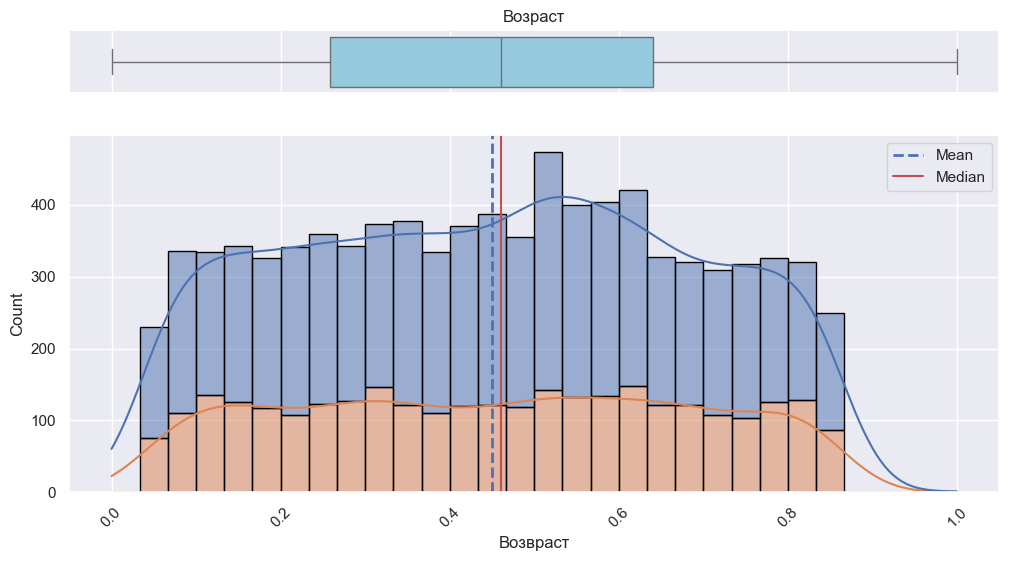

In [1004]:
visualize_numerical_feature(df=train_df, 
                            feature='Age', 
                            bins = 30, 
                            title='Возраст', 
                            xlabel='Возвраст',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Age"**:
- Данные содержат возвраст;
- Данные отмасштабированны;
- Частота сердечных приступов, для всех возврастов, примерно одинакова.

#### Количественный признак "Cholesterol"

Статистики для Cholesterol:
Уникальных значений: 282
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.27
Q3: 0.75
Количество выбросов: 0


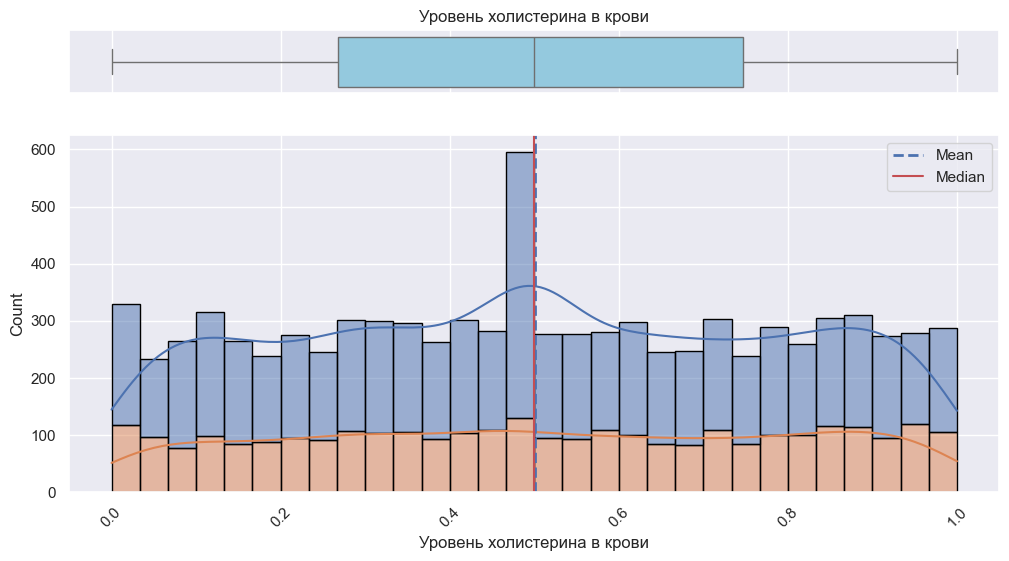

In [1005]:
visualize_numerical_feature(df=train_df, 
                            feature='Cholesterol', 
                            bins = 30, 
                            title='Уровень холистерина в крови', 
                            xlabel='Уровень холистерина в крови',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Cholesterol"**:
- Данные уровень холистерина в крови;
- Данные отмасштабированны;
- Частота сердечных приступов, для всех значений холистерина, примерно одинакова.

#### Количественный признак "Heart rate"

Статистики для Heart rate:
Уникальных значений: 86
Среднее: 0.05
Медиана: 0.05
Стандартное отклонение: 0.02
Минимум: 0.00
Максимум: 0.11
Q1: 0.03
Q3: 0.07
Количество выбросов: 0


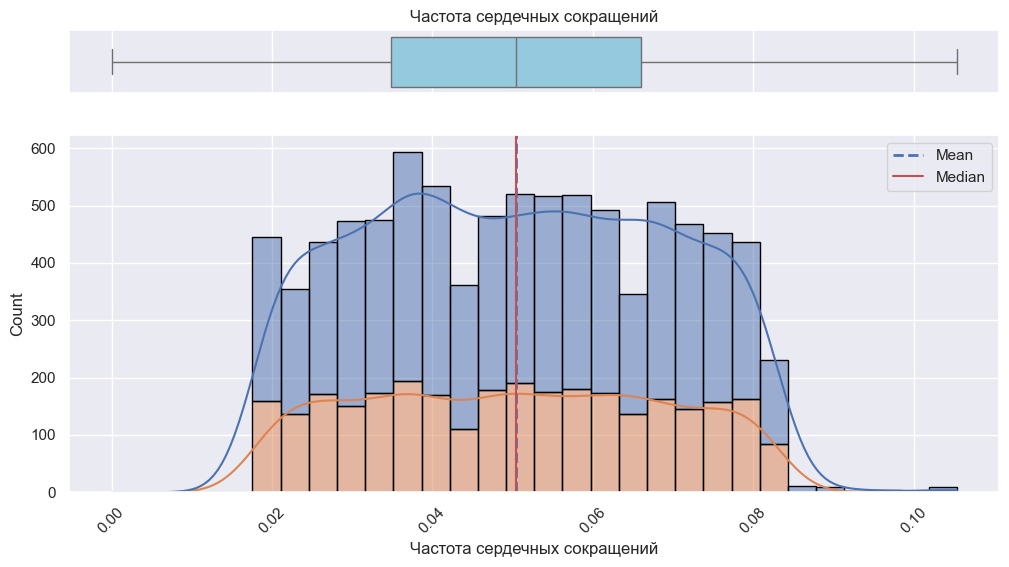

In [1006]:
visualize_numerical_feature(df=train_df, 
                            feature='Heart rate', 
                            bins = 30, 
                            title='Частота сердечных сокращений', 
                            xlabel='Частота сердечных сокращений',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Heart rate"**:
- Данные отмасштабированны;
- Частота сердечных приступов, для всех значений частоты сердечных сокращений, примерно одинакова.

#### Количественный признак "Exercise Hours Per Week"

Статистики для Exercise Hours Per Week:
Уникальных значений: 7933
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.75
Количество выбросов: 0


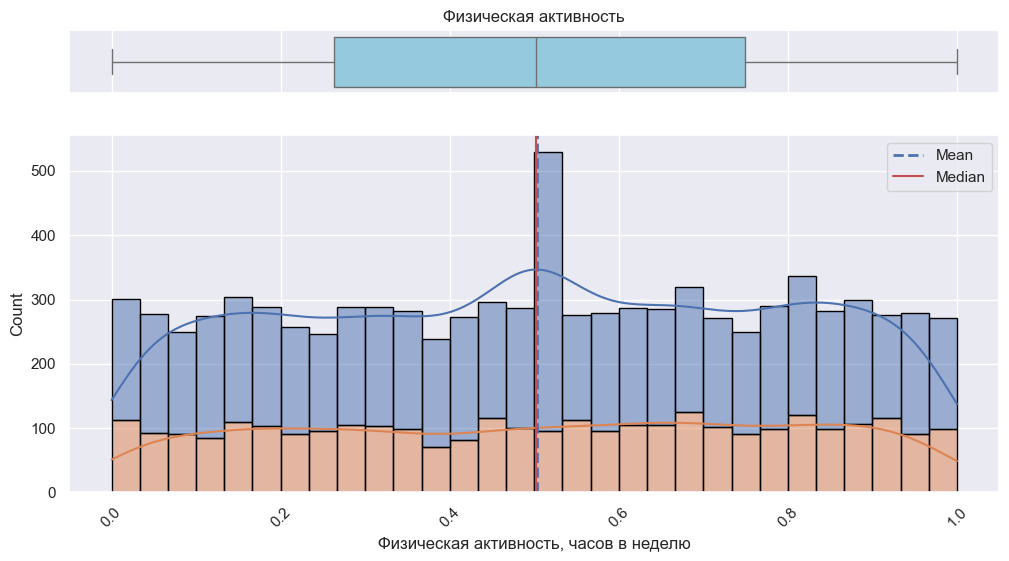

In [1007]:
visualize_numerical_feature(df=train_df, 
                            feature='Exercise Hours Per Week', 
                            bins = 30, 
                            title='Физическая активность', 
                            xlabel='Физическая активность, часов в неделю',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Exercise Hours Per Week"**:
- Данные отмасштабированны;
- Для медианного значения физической активности, имеется пик отсутствия сердечных приступов.

#### Дискретный признак "Stress Level"

Статистики для Stress Level:
Уникальных значений: 10
Среднее: 5.49
Медиана: 5.00
Стандартное отклонение: 2.87
Минимум: 1.00
Максимум: 10.00


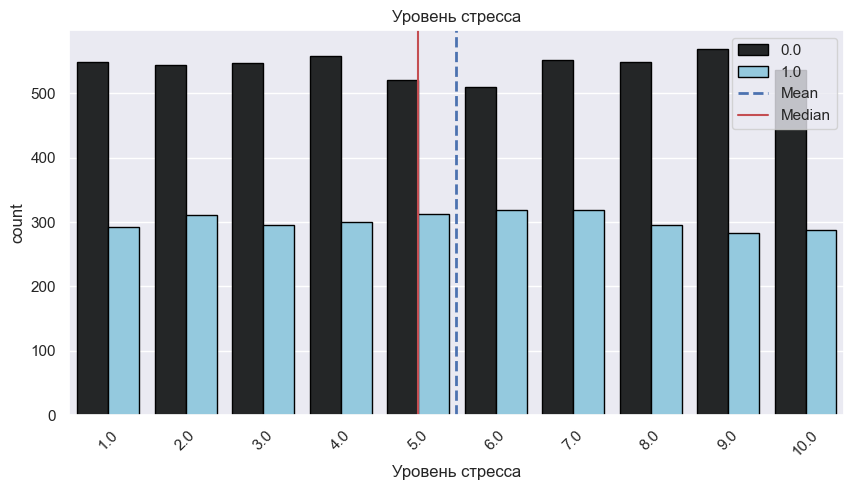

In [1008]:
visualize_numerical_feature(df=train_df, 
                            feature='Stress Level',
                            title='Уровень стресса', 
                            xlabel='Уровень стресса',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Stress Level"**:
- Для медианного значения уровня стресса = 5, наблюдается пик отсутствия сердечных приступов.

#### Количественный признак "Sedentary Hours Per Day"

Статистики для Sedentary Hours Per Day:
Уникальных значений: 7933
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.29
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.74
Количество выбросов: 0


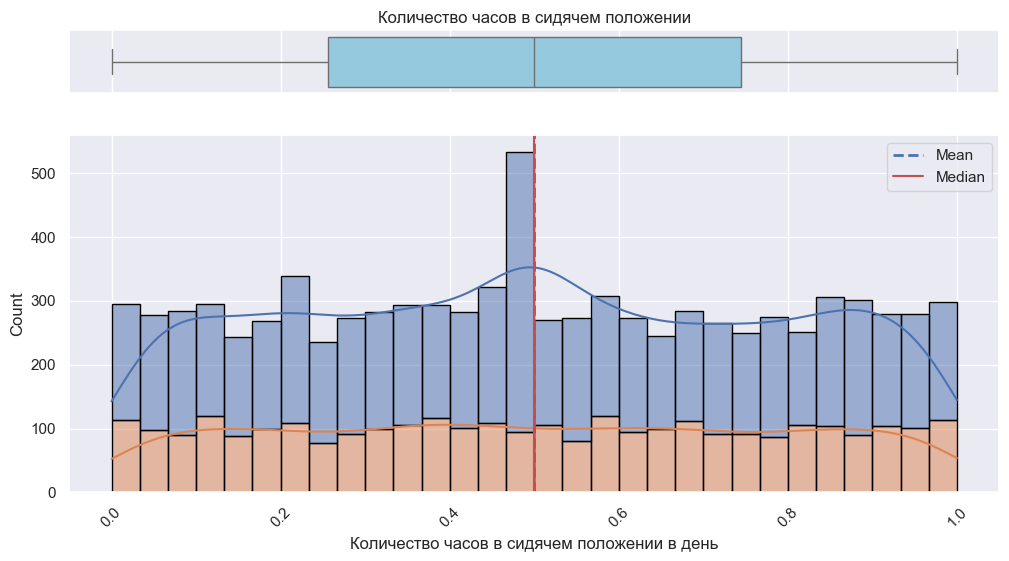

In [1009]:
visualize_numerical_feature(df=train_df, 
                            feature='Sedentary Hours Per Day', 
                            bins = 30, 
                            title='Количество часов в сидячем положении', 
                            xlabel='Количество часов в сидячем положении в день',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Sedentary Hours Per Day"**:
- Данные отмасштабированны;
- Для медианного значения количества часов в сидячем положении = 0,5, наблюдается пик отсутствия сердечных приступов.

#### Количественный признак "Income"

Статистики для Income:
Уникальных значений: 7808
Среднее: 0.50
Медиана: 0.49
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.25
Q3: 0.74
Количество выбросов: 0


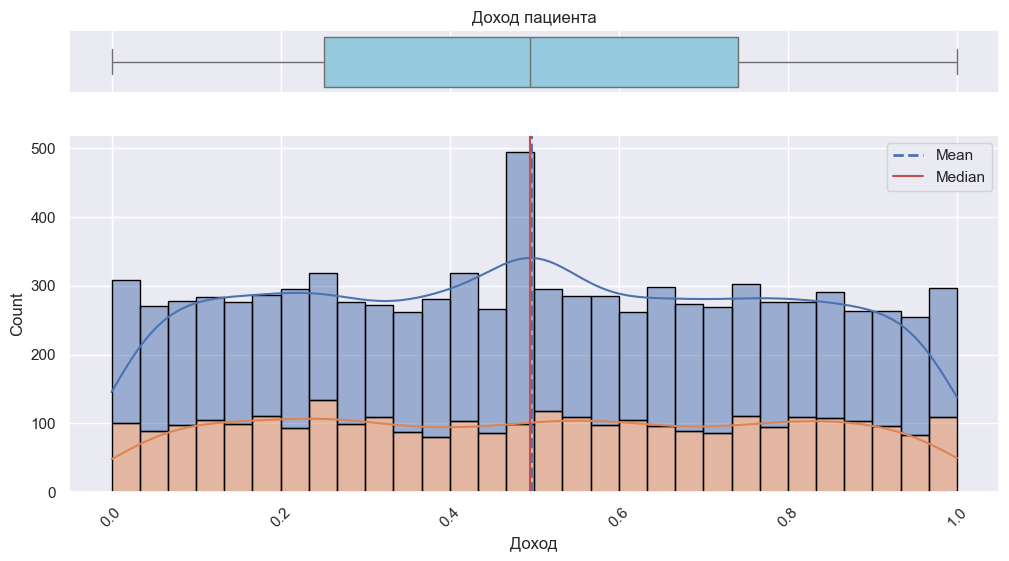

In [1010]:
visualize_numerical_feature(df=train_df, 
                            feature='Income', 
                            bins = 30, 
                            title='Доход пациента', 
                            xlabel='Доход',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Income"**:
- Данные отмасштабированны;
- Для медианного значения дохода, наблюдается пик отсутствия сердечных приступов.

#### Количественный признак "BMI"

Статистики для BMI:
Уникальных значений: 7933
Среднее: 0.50
Медиана: 0.49
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.25
Q3: 0.74
Количество выбросов: 0


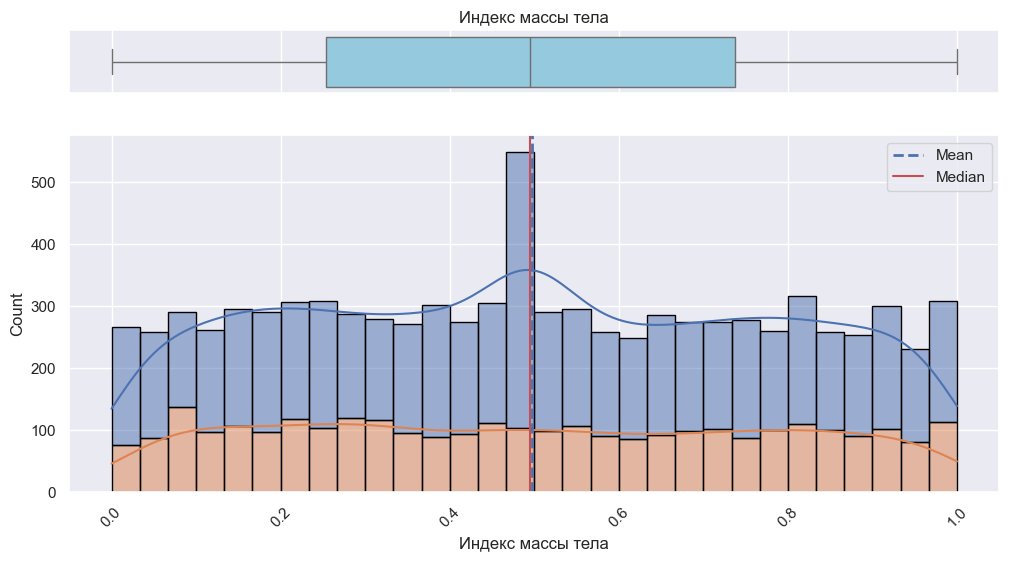

In [1011]:
visualize_numerical_feature(df=train_df, 
                            feature='BMI', 
                            bins = 30, 
                            title='Индекс массы тела', 
                            xlabel='Индекс массы тела',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "BMI"**:
- Данные отмасштабированны;
- Для медианного значения индекса массы тела, наблюдается пик отсутствия сердечных приступов.

#### Количественный признак "Triglycerides"

Статистики для Triglycerides:
Уникальных значений: 772
Среднее: 0.51
Медиана: 0.50
Стандартное отклонение: 0.29
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.75
Количество выбросов: 0


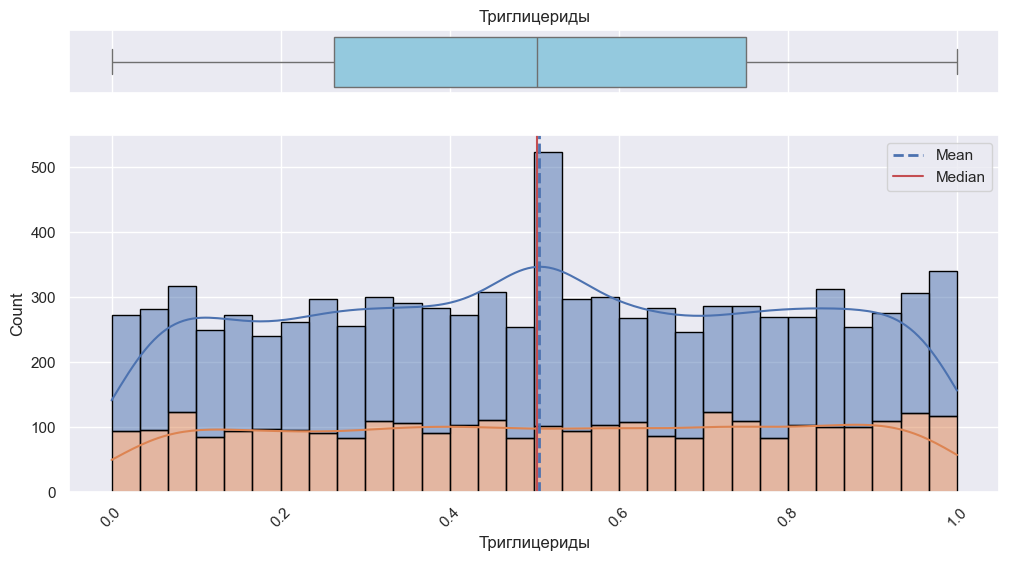

In [1012]:
visualize_numerical_feature(df=train_df, 
                            feature='Triglycerides', 
                            bins = 30, 
                            title='Триглицериды', 
                            xlabel='Триглицериды',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Triglycerides"**:
- Данные отмасштабированны;
- Для медианного значения триглицеридов, наблюдается пик отсутствия сердечных приступов.

#### Дискретный признак "Physical Activity Days Per Week"

Статистики для Physical Activity Days Per Week:
Уникальных значений: 8
Среднее: 3.51
Медиана: 3.00
Стандартное отклонение: 2.28
Минимум: 0.00
Максимум: 7.00


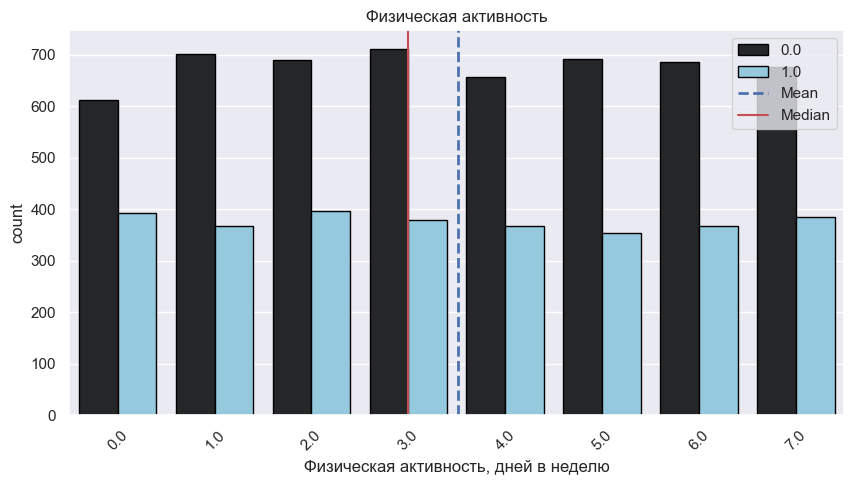

In [1013]:
visualize_numerical_feature(df=train_df, 
                            feature='Physical Activity Days Per Week',
                            title='Физическая активность', 
                            xlabel='Физическая активность, дней в неделю',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Physical Activity Days Per Week"**:
- Для медианного значения физической активности = 3, наблюдается пик отсутствия сердечных приступов.

#### Дискретный признак "Sleep Hours Per Day"

Статистики для Sleep Hours Per Day:
Уникальных значений: 8
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.33
Минимум: 0.00
Максимум: 1.00


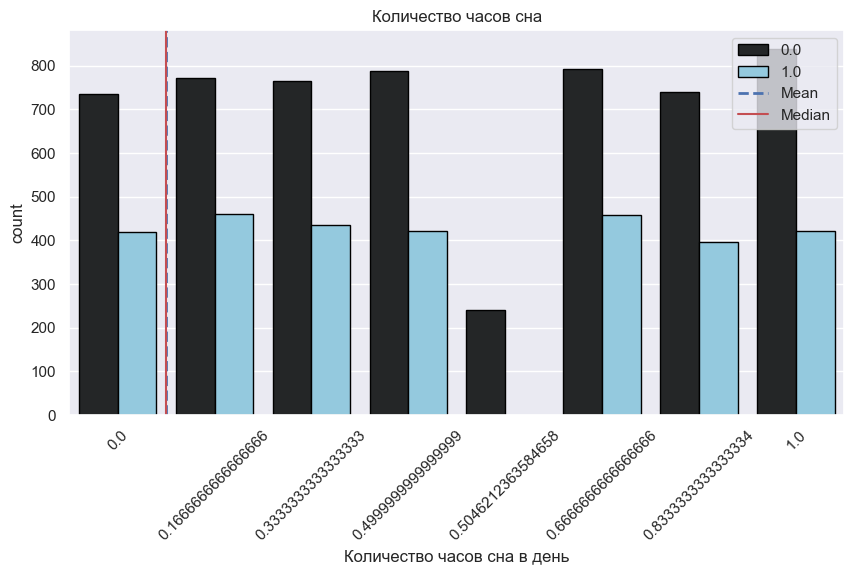

In [1014]:
visualize_numerical_feature(df=train_df, 
                            feature='Sleep Hours Per Day',
                            title='Количество часов сна', 
                            xlabel='Количество часов сна в день',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Sleep Hours Per Day"**:
- Данные отмасштабированны;
- отсутсвуют данные по риску сердечного приступа для 0,5 часов сна

#### Количественный признак "Blood sugar"

Статистики для Blood sugar:
Уникальных значений: 239
Среднее: 0.23
Медиана: 0.23
Стандартное отклонение: 0.08
Минимум: 0.00
Максимум: 1.00
Q1: 0.23
Q3: 0.23
Количество выбросов: 2132


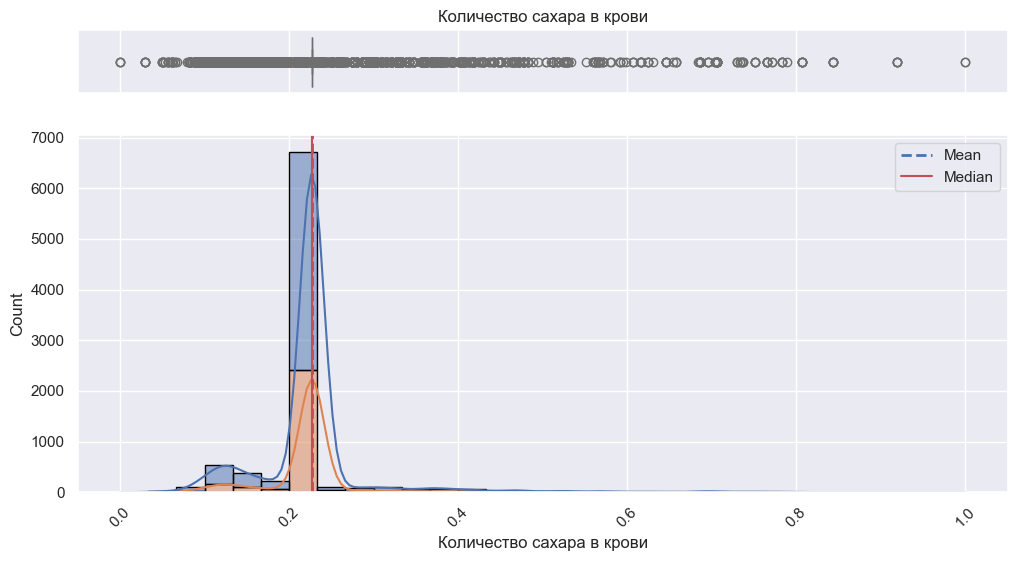

In [1015]:
visualize_numerical_feature(df=train_df, 
                            feature='Blood sugar', 
                            bins = 30, 
                            title='Количество сахара в крови', 
                            xlabel='Количество сахара в крови',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Blood sugar"**:
- Данные отмасштабированны;
- Распределение имеет тяжелый хвост.

#### Количественный признак "CK-MB"

Статистики для CK-MB:
Уникальных значений: 678
Среднее: 0.05
Медиана: 0.05
Стандартное отклонение: 0.08
Минимум: 0.00
Максимум: 1.00
Q1: 0.05
Q3: 0.05
Количество выбросов: 2132


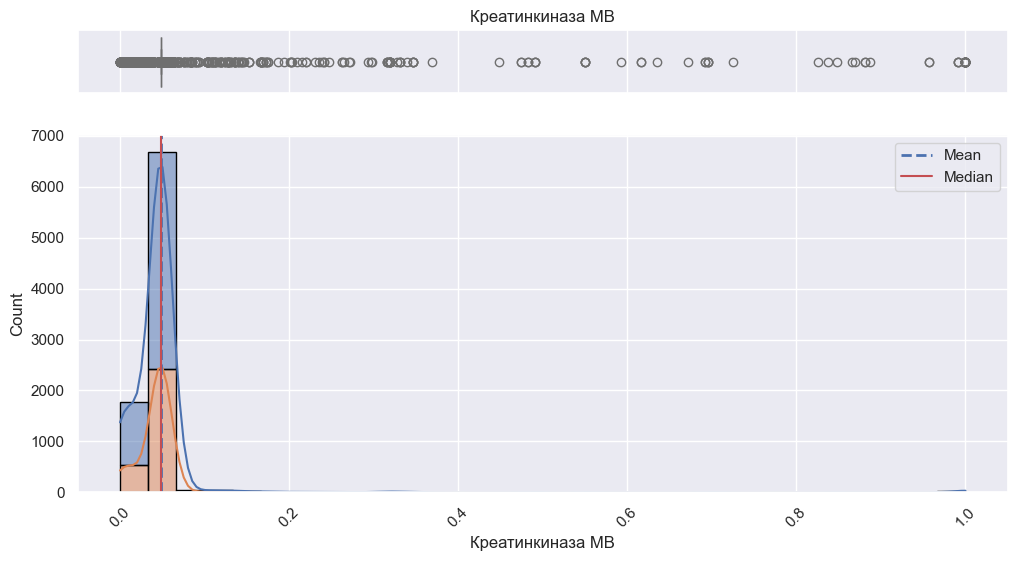

In [1016]:
visualize_numerical_feature(df=train_df, 
                            feature='CK-MB', 
                            bins = 30, 
                            title='Креатинкиназа МВ', 
                            xlabel='Креатинкиназа МВ',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "CK-MB"**:
- Данные отмасштабированны;
- Распределение имеет тяжелый хвост.

#### Количественный признак "Troponin"

Статистики для Troponin:
Уникальных значений: 340
Среднее: 0.04
Медиана: 0.04
Стандартное отклонение: 0.06
Минимум: 0.00
Максимум: 1.00
Q1: 0.04
Q3: 0.04
Количество выбросов: 2132


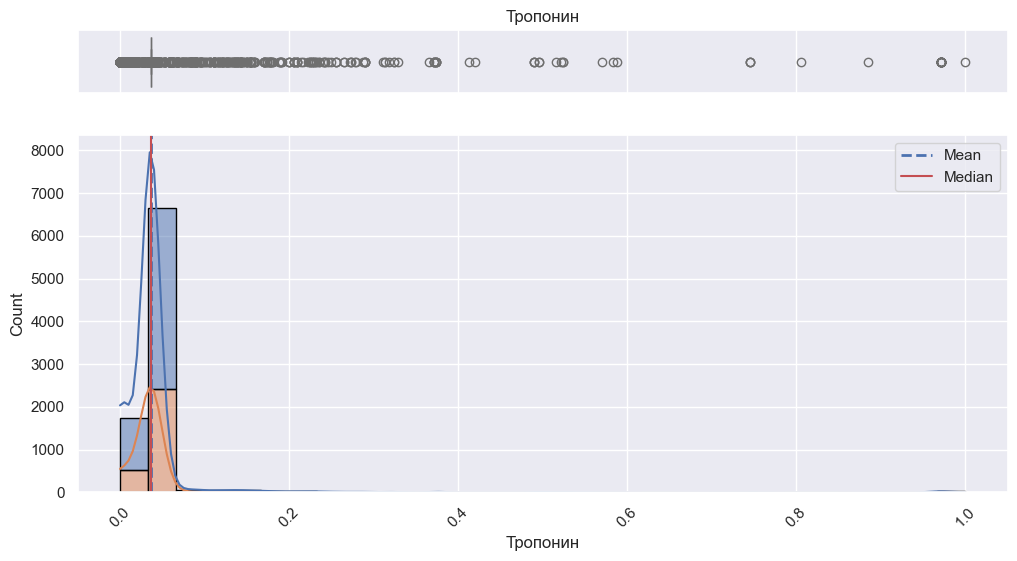

In [1017]:
visualize_numerical_feature(df=train_df, 
                            feature='Troponin', 
                            bins = 30, 
                            title='Тропонин', 
                            xlabel='Тропонин',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Troponin"**:
- Данные отмасштабированны;
- Распределение имеет тяжелый хвост.

#### Количественный признак "Systolic blood pressure"

Статистики для Systolic blood pressure:
Уникальных значений: 100
Среднее: 0.45
Медиана: 0.45
Стандартное отклонение: 0.17
Минимум: 0.00
Максимум: 1.00
Q1: 0.30
Q3: 0.60
Количество выбросов: 0


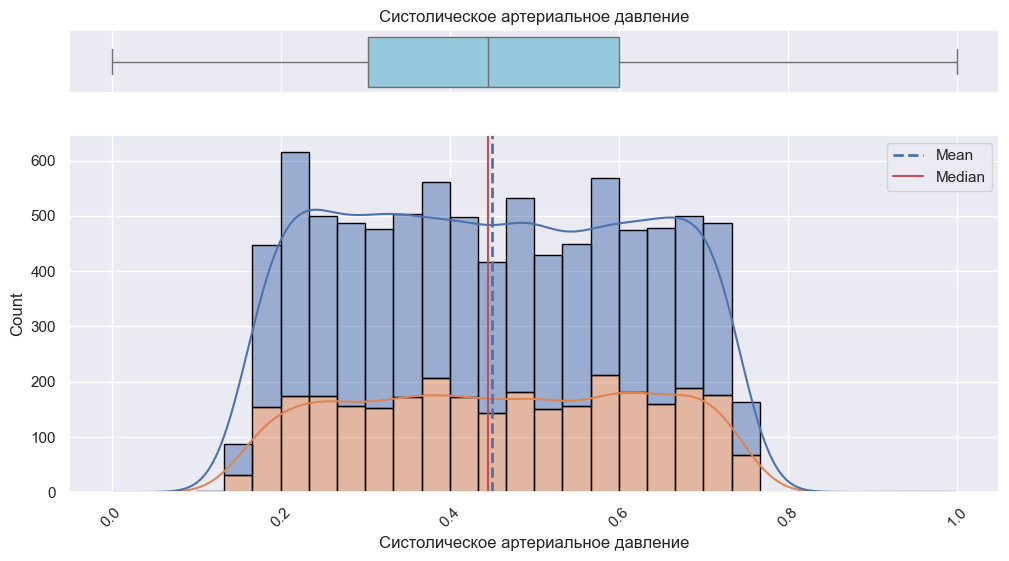

In [1018]:
visualize_numerical_feature(df=train_df, 
                            feature='Systolic blood pressure', 
                            bins = 30, 
                            title='Систолическое артериальное давление', 
                            xlabel='Систолическое артериальное давление',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Systolic blood pressure"**:
- Данные отмасштабированны;

#### Количественный признак "Diastolic blood pressure"

Статистики для Diastolic blood pressure:
Уникальных значений: 66
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.17
Минимум: 0.00
Максимум: 1.00
Q1: 0.35
Q3: 0.65
Количество выбросов: 0


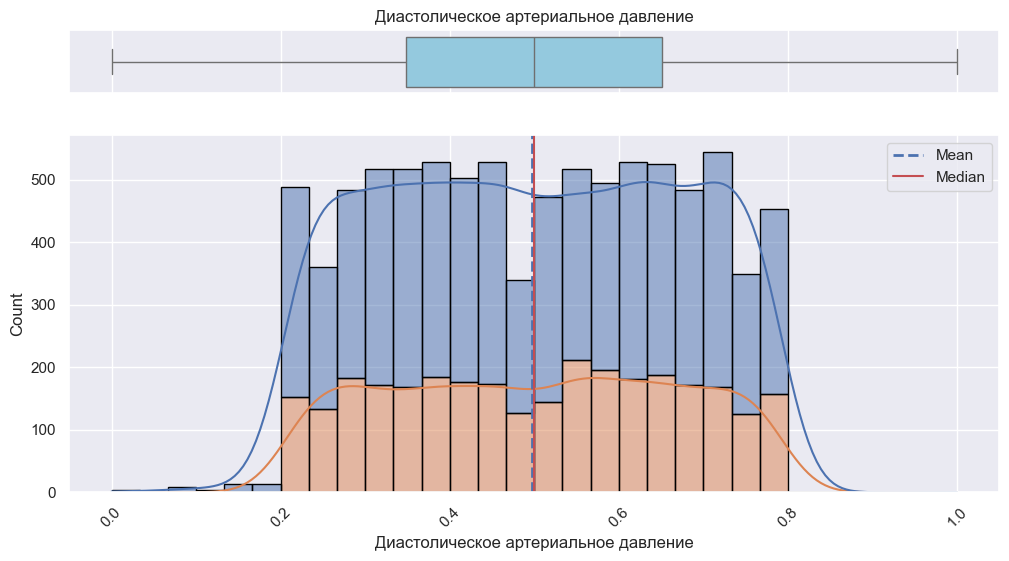

In [1019]:
visualize_numerical_feature(df=train_df, 
                            feature='Diastolic blood pressure', 
                            bins = 30, 
                            title='Диастолическое артериальное давление', 
                            xlabel='Диастолическое артериальное давление',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Diastolic blood pressure"**:
- Данные отмасштабированны;

### Категориальный признак "Diabetes"

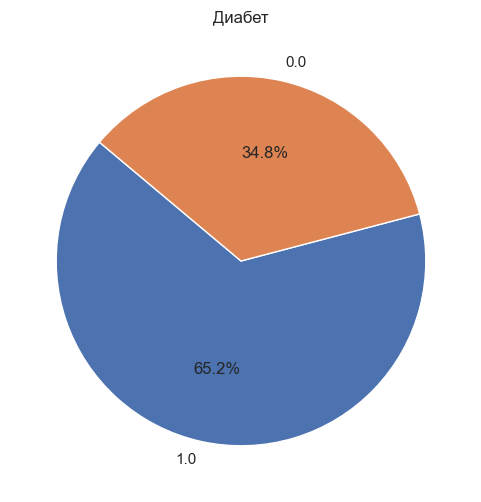

Статистика для Diabetes:
- Уникальные значения: 2

- Мода: 1.0

- Частота по категориям:
Diabetes
1.00    5505
0.00    2937
Name: count, dtype: int64

- Процентное соотношение:
Diabetes
1.00   65.00
0.00   35.00
Name: proportion, dtype: float64


In [1020]:
visualize_categorical_feature(df=train_df, 
                              feature='Diabetes',
                             title='Диабет')

### Категориальный признак "Family History"

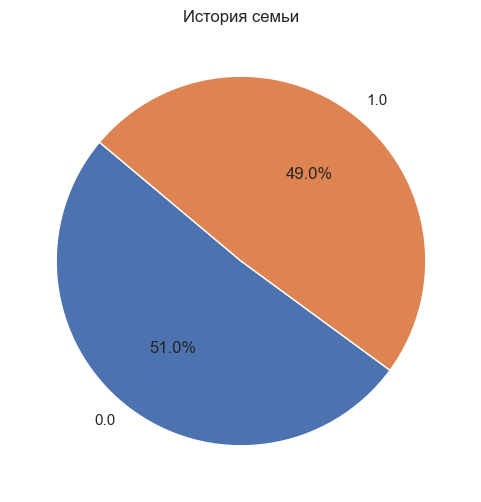

Статистика для Family History:
- Уникальные значения: 2

- Мода: 0.0

- Частота по категориям:
Family History
0.00    4309
1.00    4133
Name: count, dtype: int64

- Процентное соотношение:
Family History
0.00   51.00
1.00   49.00
Name: proportion, dtype: float64


In [1021]:
visualize_categorical_feature(df=train_df, 
                              feature='Family History',
                             title='История семьи')

### Категориальный признак "Smoking"

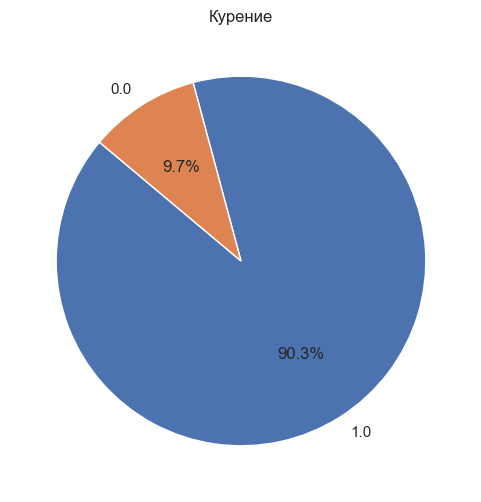

Статистика для Smoking:
- Уникальные значения: 2

- Мода: 1.0

- Частота по категориям:
Smoking
1.00    7622
0.00     820
Name: count, dtype: int64

- Процентное соотношение:
Smoking
1.00   90.00
0.00   10.00
Name: proportion, dtype: float64


In [1022]:
visualize_categorical_feature(df=train_df, 
                              feature='Smoking',
                             title='Курение')

### Категориальный признак "Obesity"

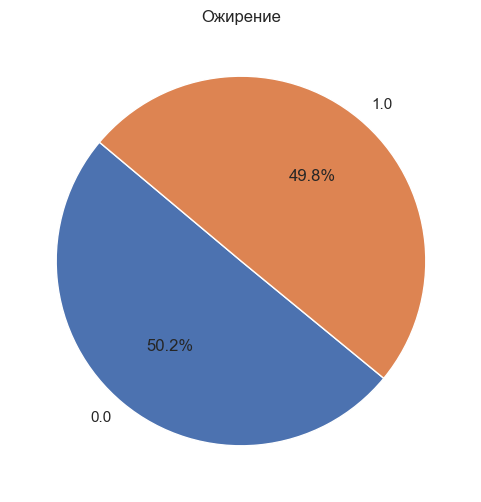

Статистика для Obesity:
- Уникальные значения: 2

- Мода: 0.0

- Частота по категориям:
Obesity
0.00    4235
1.00    4207
Name: count, dtype: int64

- Процентное соотношение:
Obesity
0.00   50.00
1.00   50.00
Name: proportion, dtype: float64


In [1023]:
visualize_categorical_feature(df=train_df, 
                              feature='Obesity',
                             title='Ожирение')

### Категориальный признак "Alcohol Consumption"

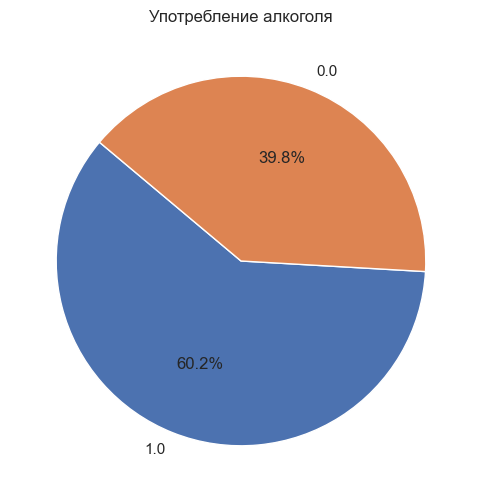

Статистика для Alcohol Consumption:
- Уникальные значения: 2

- Мода: 1.0

- Частота по категориям:
Alcohol Consumption
1.00    5082
0.00    3360
Name: count, dtype: int64

- Процентное соотношение:
Alcohol Consumption
1.00   60.00
0.00   40.00
Name: proportion, dtype: float64


In [1024]:
visualize_categorical_feature(df=train_df, 
                              feature='Alcohol Consumption',
                             title='Употребление алкоголя')

### Категориальный признак "Diet"

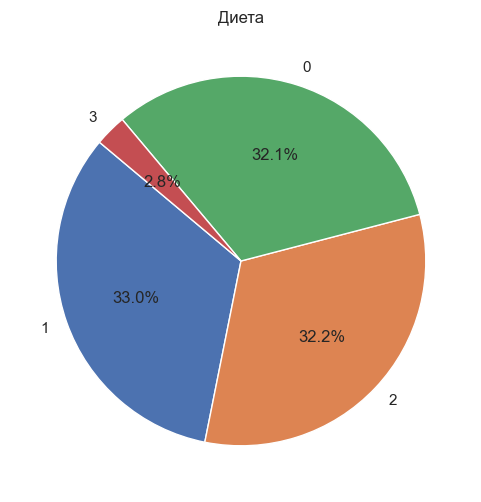

Статистика для Diet:
- Уникальные значения: 4

- Мода: 1

- Частота по категориям:
Diet
1    2863
2    2796
0    2783
3     241
Name: count, dtype: int64

- Процентное соотношение:
Diet
1   33.00
2   32.00
0   32.00
3    3.00
Name: proportion, dtype: float64


In [1025]:
visualize_categorical_feature(df=train_df, 
                              feature='Diet',
                             title='Диета')

### Категориальный признак "Previous Heart Problems"

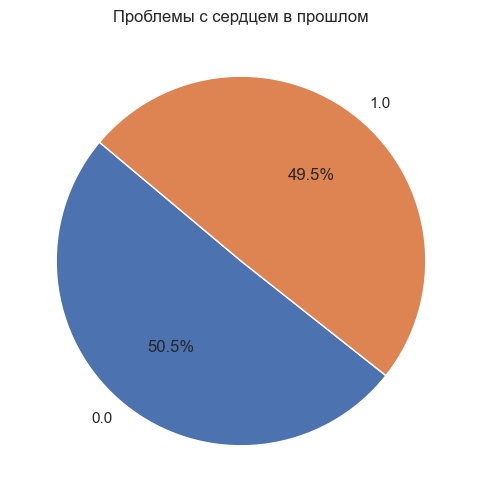

Статистика для Previous Heart Problems:
- Уникальные значения: 2

- Мода: 0.0

- Частота по категориям:
Previous Heart Problems
0.00    4260
1.00    4182
Name: count, dtype: int64

- Процентное соотношение:
Previous Heart Problems
0.00   50.00
1.00   50.00
Name: proportion, dtype: float64


In [1026]:
visualize_categorical_feature(df=train_df, 
                              feature='Previous Heart Problems',
                             title='Проблемы с сердцем в прошлом')

### Категориальный признак "Medication Use"

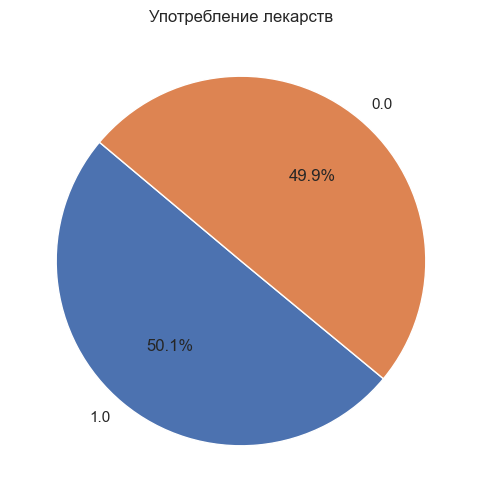

Статистика для Medication Use:
- Уникальные значения: 2

- Мода: 1.0

- Частота по категориям:
Medication Use
1.00    4231
0.00    4211
Name: count, dtype: int64

- Процентное соотношение:
Medication Use
1.00   50.00
0.00   50.00
Name: proportion, dtype: float64


In [1027]:
visualize_categorical_feature(df=train_df, 
                              feature='Medication Use',
                             title='Употребление лекарств')

### Категориальный признак "Gender"

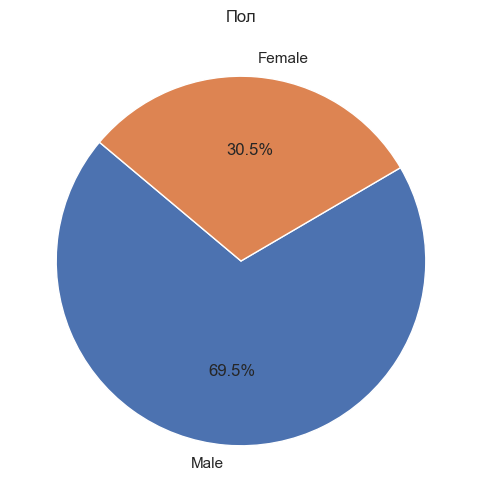

Статистика для Gender:
- Уникальные значения: 2

- Мода: Male

- Частота по категориям:
Gender
Male      6038
Female    2645
Name: count, dtype: int64

- Процентное соотношение:
Gender
Male     70.00
Female   30.00
Name: proportion, dtype: float64


In [1028]:
visualize_categorical_feature(df=train_df, 
                              feature='Gender',
                             title='Пол')

### Категориальный признак "Heart Attack Risk (Binary)"

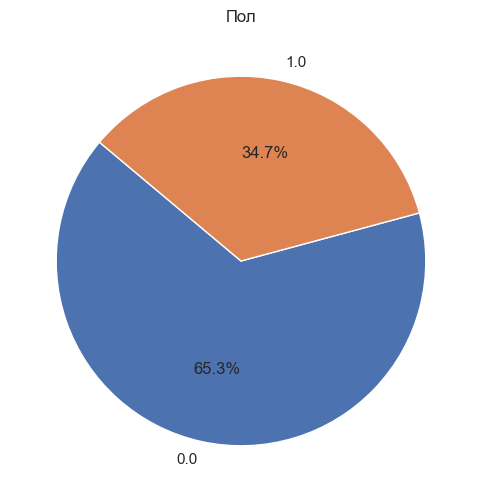

Статистика для Heart Attack Risk (Binary):
- Уникальные значения: 2

- Мода: 0.0

- Частота по категориям:
Heart Attack Risk (Binary)
0.00    5670
1.00    3013
Name: count, dtype: int64

- Процентное соотношение:
Heart Attack Risk (Binary)
0.00   65.00
1.00   35.00
Name: proportion, dtype: float64


In [1029]:
visualize_categorical_feature(df=train_df, 
                              feature='Heart Attack Risk (Binary)',
                             title='Пол')

### Корреляционный анализ

In [1030]:
train_df.sort_values('id').head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
7250,0.60,0.10,0.05,1.00,1.00,1.00,1.00,1.00,0.75,1,...,2.00,0.67,0.00,0.23,0.05,0.04,Male,0.57,0.57,1
4034,0.60,0.19,0.05,0.00,0.00,1.00,0.00,1.00,0.20,2,...,4.00,1.00,0.00,0.23,0.05,0.04,Male,0.19,0.67,2
8326,0.08,0.79,0.07,1.00,0.00,1.00,1.00,0.00,0.60,2,...,1.00,0.17,0.00,0.23,0.05,0.04,Male,0.25,0.38,4
7880,0.08,0.77,0.07,1.00,1.00,1.00,0.00,1.00,0.66,2,...,2.00,0.67,0.00,0.23,0.05,0.04,Male,0.74,0.38,5
5314,0.08,0.49,0.07,1.00,0.00,1.00,0.00,0.00,0.85,1,...,0.00,1.00,1.00,0.23,0.05,0.04,Male,0.42,0.72,6


In [1031]:
# посчитаем корреляции 
train_phik_overview = train_df.drop(['id'], axis=1).phik_matrix(interval_cols=numerical_features)
print(train_phik_overview.shape)

(26, 26)


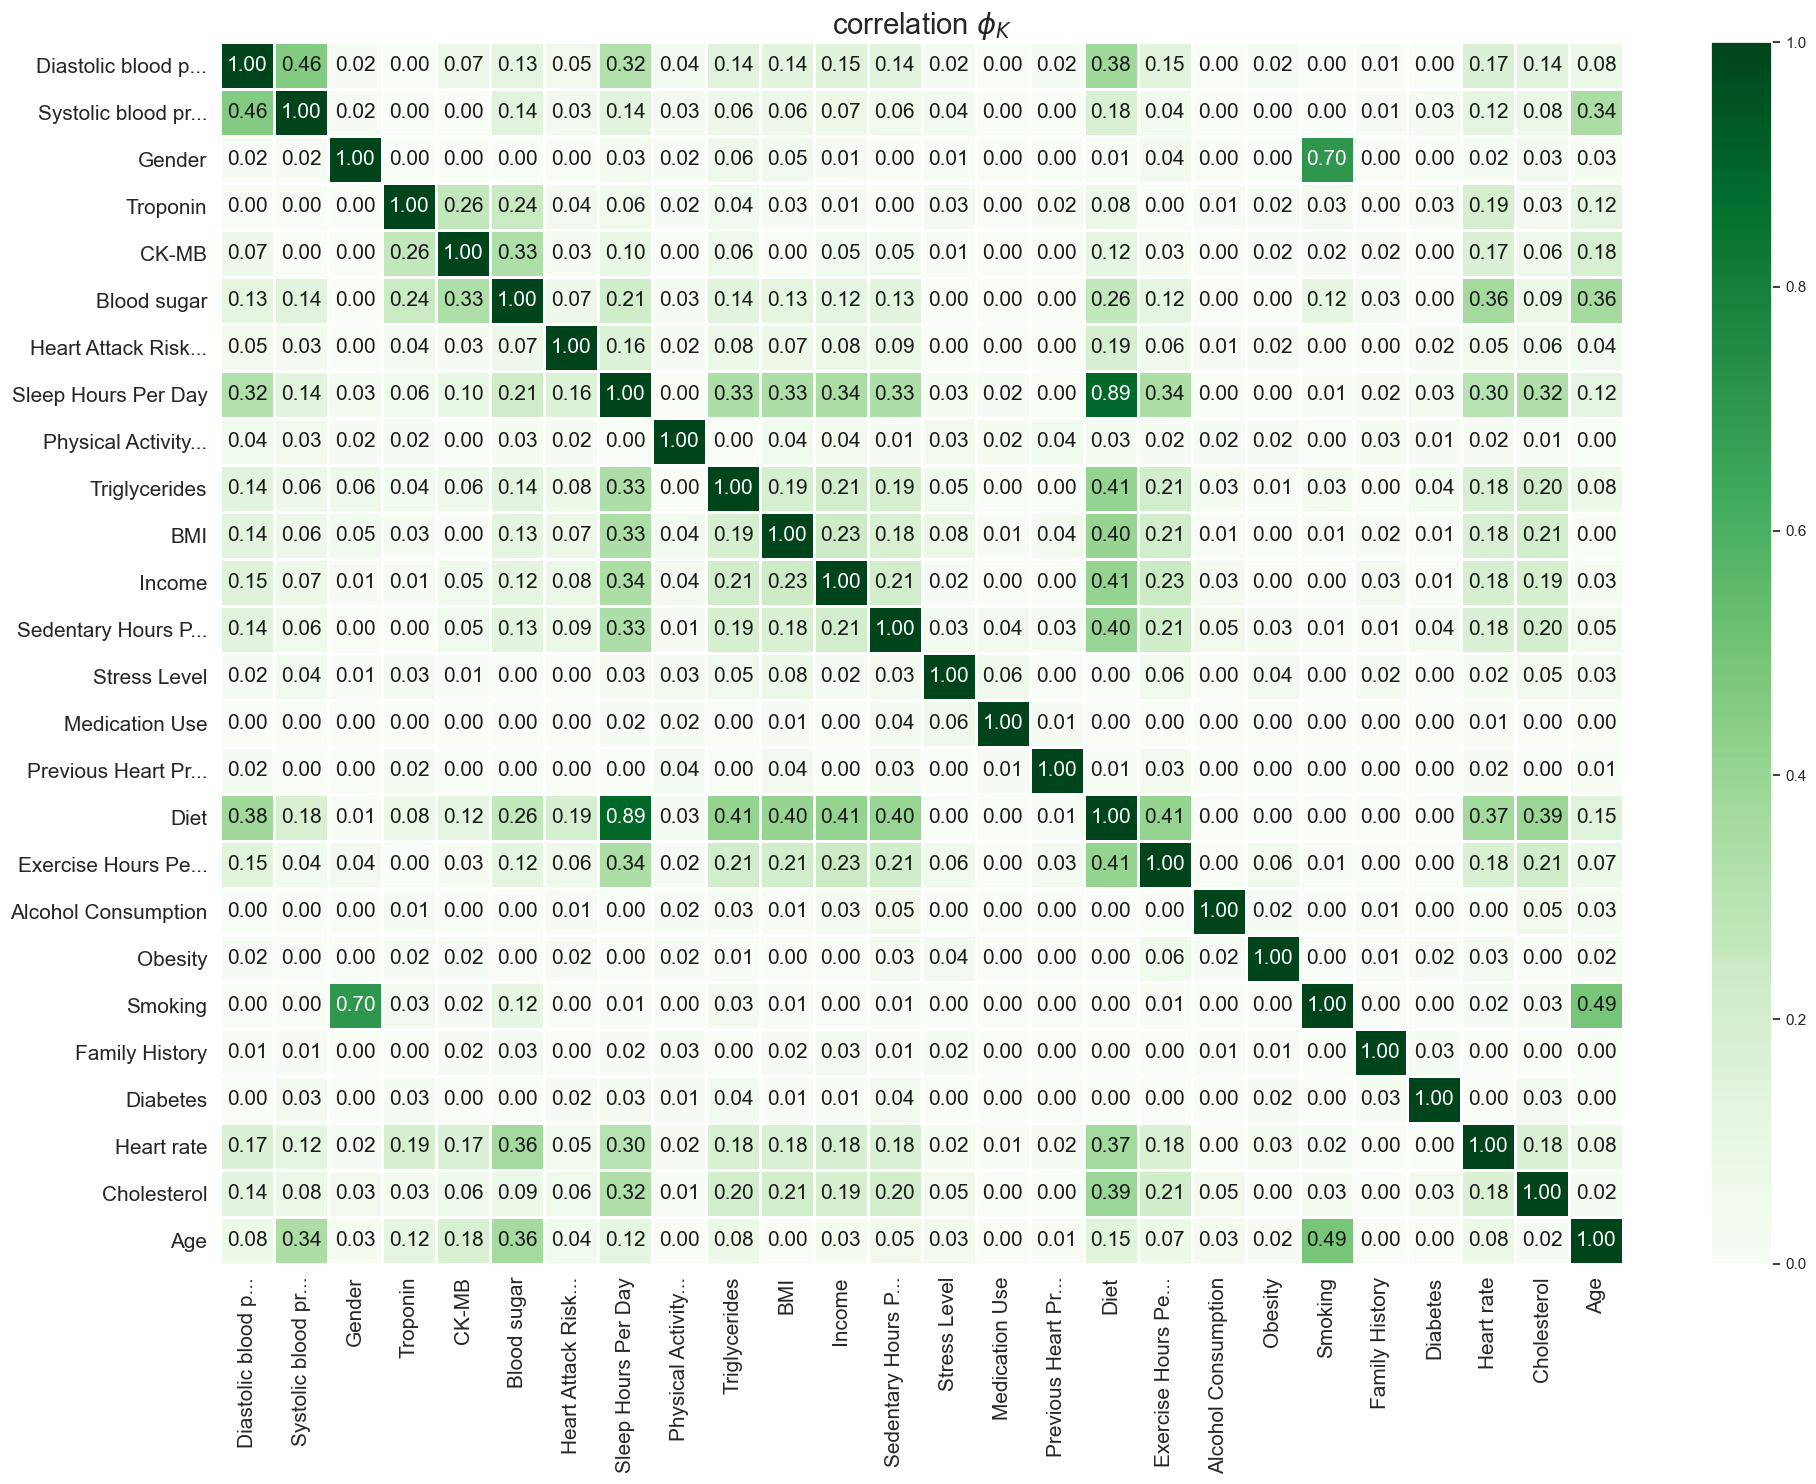

In [1032]:
plot_correlation_matrix(
    train_phik_overview.values,
    x_labels=train_phik_overview.columns,
    y_labels=train_phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Вывод по разделу **"Иследование данных"**:
- Данные имеют плохое качество;
- Высокая кореляция между Diet и Sleep Hours Per Day

## Обучение моделей

При обучении модели, мы будем использовать метрику ROC-AUC по причине:
- несбалансированный целевой признак
- выбросы в данных

### Пайплайн моделей

In [1033]:
def trans_func(input):
    """
    Преобразует входные данные и заменяет значения.

    Функция заменяет 1.0 и 0.0 на Male и Female соответственно

    Параметры:
    - input: Массив или список данных, которые необходимо обработать.

    Возвращает:
    - Обработанный массив NumPy с замененными значениями.
    """
    
    if not isinstance(input, np.ndarray):
        input = np.array(input)

    # заменяем ' ' на Nan
    output = np.where(input == '1.0', 'Male', input)
    output = np.where(input == '0.0', 'Female', output)

    return output

transformer = FunctionTransformer(trans_func)

In [1034]:
# Выполним разделение датафреймов
X_train = train_df.drop(['id', 'Heart Attack Risk (Binary)'], axis=1)
y_train = train_df['Heart Attack Risk (Binary)']

X_test = test_df.drop(['id'], axis=1)

In [1035]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8683 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8683 non-null   float64
 1   Cholesterol                      8683 non-null   float64
 2   Heart rate                       8683 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8683 non-null   float64
 9   Diet                             8683 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level             

In [1036]:
ohe_columns = [
    'Gender'
]

ord_columns = ['Stress Level',
    'Physical Activity Days Per Week',
    'Sleep Hours Per Day'
]

num_columns = [
    'Age',
    'Cholesterol',
    'Heart rate',
    'Exercise Hours Per Week',
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    'Blood sugar',
    'CK-MB',
    'Troponin',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Diet',
    'Previous Heart Problems',
    'Medication Use'
]

In [1037]:
# Пайплайн для подготовки признаков из списка ohe_columns:
# - заполнение пропусков
# - OHE- кодирование

ohe_pipe = Pipeline(
    [
        ("trans", transformer),
        ('SimpeImputer_ohe', SimpleImputer(missing_values=np.nan, 
                                           strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [1038]:
# Пайплайн для подготовки признаков из списка ohe_columns:
# - заполнение пропусков
# - OHE- кодирование

ohe_pipe = Pipeline(
    [
        ('SimpeImputer_ohe', SimpleImputer(missing_values=np.nan, 
                                           strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [1039]:
# Пайплайн для подготовки признаков из списка ord_columns
# - заполнение пропусков
# - Ordinal-кодирование

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan,
                                                  strategy='median')),
        ('ord', OrdinalEncoder(categories=[[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], 
                                           [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
                                           [0.0,
                                             0.1666666666666666,
                                             0.3333333333333333,
                                             0.4999999999999999,
                                             0.5046212363584658,
                                             0.6666666666666666,
                                             0.8333333333333334,
                                             1.0]
                                          ],
                               handle_unknown='use_encoded_value',
                               unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='median'))
    ]
)

In [1040]:
# Пайплайн для подготовки количественных признаков
num_pipe = Pipeline(
    [
        ('SimpeImputer_num', SimpleImputer(missing_values=np.nan, 
                                           strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [1041]:
# Пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

In [1042]:
# Итоговый пайплайн
final_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

In [1043]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': distributions.CategoricalDistribution([DecisionTreeClassifier(random_state=RANDOM_STATE)]),
        'models__max_depth': distributions.IntDistribution(5, 12),
        'models__max_features': distributions.IntDistribution(5, 12),
        'preprocessor__num__scaler': distributions.CategoricalDistribution(['passthrough'])
    },
    
    # LGBMClassifier
    {
        'models': distributions.CategoricalDistribution([lgb.LGBMClassifier(random_state=RANDOM_STATE)]),
        'models__learning_rate': distributions.CategoricalDistribution([0.001, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5]),
        'models__num_leaves': distributions.CategoricalDistribution([1, 2, 4, 6, 8, 10, 15, 20, 30, 50]),
        'models__n_estimators': distributions.CategoricalDistribution([25, 50, 100, 125, 150]),
        'models__max_depth': distributions.IntDistribution(2, 10),
        'preprocessor__num__scaler': distributions.CategoricalDistribution(['passthrough'])
    },
    

    # словарь для модели LogisticRegression()
    {
        'models': distributions.CategoricalDistribution([LogisticRegression(random_state=RANDOM_STATE, 
                                                              penalty='elasticnet', 
                                                              solver='saga')]),
        'models__l1_ratio': distributions.CategoricalDistribution([0, 0.1, 0.2, 0.3, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'models__C': distributions.IntDistribution(1, 6),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': distributions.CategoricalDistribution([KNeighborsClassifier()]),
        'models__n_neighbors': distributions.IntDistribution(2, 6),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    }
]

optuna_tree = OptunaSearchCV(
        final_pipe,
        param_grid[0],
        cv=5,
        scoring='roc_auc',
        n_trials=15,
        random_state=RANDOM_STATE
    )

optuna_lgbm= OptunaSearchCV(
        final_pipe,
        param_grid[1],
        cv=5,
        scoring='roc_auc',
        n_trials=100,
        random_state=RANDOM_STATE
    )

optuna_logistic = OptunaSearchCV(
        final_pipe,
        param_grid[2],
        cv=5,
        scoring='roc_auc',
        n_trials=1,
        random_state=RANDOM_STATE
    )

optuna_knn = OptunaSearchCV(
        final_pipe,
        param_grid[3],
        cv=5,
        scoring='roc_auc',
        n_trials=10,
        random_state=RANDOM_STATE
    )

In [1044]:
optuna_tree.fit(X_train, y_train)
print()

[I 2025-08-24 18:46:19,476] A new study created in memory with name: no-name-05b1322b-cad8-452a-8298-760147a35d90
[I 2025-08-24 18:46:19,813] Trial 0 finished with value: 0.5272962131574661 and parameters: {'models': DecisionTreeClassifier(max_depth=8, max_features=11, random_state=42), 'models__max_depth': 8, 'models__max_features': 11, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 0 with value: 0.5272962131574661.
[I 2025-08-24 18:46:20,064] Trial 1 finished with value: 0.527372612990757 and parameters: {'models': DecisionTreeClassifier(max_depth=5, max_features=7, random_state=42), 'models__max_depth': 5, 'models__max_features': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.527372612990757.
[I 2025-08-24 18:46:20,339] Trial 2 finished with value: 0.5332934772719515 and parameters: {'models': DecisionTreeClassifier(max_depth=8, max_features=7, random_state=42), 'models__max_depth': 8, 'models__max_features': 7, 'preprocessor__num__scaler':

In [1045]:
optuna_lgbm.fit(X_train, y_train)
print()

[I 2025-08-24 18:46:24,223] A new study created in memory with name: no-name-62e74171-7aed-4001-b4cf-123294939661


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] 

[I 2025-08-24 18:46:24,590] Trial 0 finished with value: 0.5379913322911051 and parameters: {'models': LGBMClassifier(learning_rate=0.05, max_depth=9, n_estimators=25, num_leaves=8,
               random_state=42), 'models__learning_rate': 0.05, 'models__num_leaves': 8, 'models__n_estimators': 25, 'models__max_depth': 9, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 0 with value: 0.5379913322911051.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] 

[I 2025-08-24 18:46:25,222] Trial 1 finished with value: 0.5629844706168513 and parameters: {'models': LGBMClassifier(max_depth=6, n_estimators=125, num_leaves=20, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 20, 'models__n_estimators': 125, 'models__max_depth': 6, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5629844706168513.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:25,519] Trial 2 finished with value: 0.516300927719931 and parameters: {'models': LGBMClassifier(max_depth=2, n_estimators=25, num_leaves=15, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 15, 'models__n_estimators': 25, 'models__max_depth': 2, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5629844706168513.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:25,843] Trial 3 finished with value: 0.5214286015513359 and parameters: {'models': LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=25, num_leaves=20,
               random_state=42), 'models__learning_rate': 0.05, 'models__num_leaves': 20, 'models__n_estimators': 25, 'models__max_depth': 3, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5629844706168513.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:26,200] Trial 4 finished with value: 0.5345826273796244 and parameters: {'models': LGBMClassifier(max_depth=3, n_estimators=50, num_leaves=30, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 30, 'models__n_estimators': 50, 'models__max_depth': 3, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5629844706168513.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-24 18:46:26,728] Trial 5 finished with value: 0.5647651443194768 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=9, n_estimators=150, num_leaves=10,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 10, 'models__n_estimators': 150, 'models__max_depth': 9, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 5 with value: 0.5647651443194768.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGB

[I 2025-08-24 18:46:27,373] Trial 6 finished with value: 0.5731646347744521 and parameters: {'models': LGBMClassifier(learning_rate=0.3, max_depth=10, n_estimators=150, num_leaves=20,
               random_state=42), 'models__learning_rate': 0.3, 'models__num_leaves': 20, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] 

[I 2025-08-24 18:46:27,786] Trial 7 finished with value: 0.5263329376756796 and parameters: {'models': LGBMClassifier(learning_rate=0.001, max_depth=10, n_estimators=50,
               num_leaves=15, random_state=42), 'models__learning_rate': 0.001, 'models__num_leaves': 15, 'models__n_estimators': 50, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004


[W 2025-08-24 18:46:27,975] Trial 8 failed with parameters: {'models': LGBMClassifier(max_depth=10, n_estimators=25, num_leaves=1, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 1, 'models__n_estimators': 25, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:27,976] Trial 8 failed with value nan.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:28,275] Trial 9 finished with value: 0.5284971808153244 and parameters: {'models': LGBMClassifier(learning_rate=0.3, max_depth=2, n_estimators=25, num_leaves=20,
               random_state=42), 'models__learning_rate': 0.3, 'models__num_leaves': 20, 'models__n_estimators': 25, 'models__max_depth': 2, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:28,618] Trial 10 finished with value: 0.5178941299681269 and parameters: {'models': LGBMClassifier(learning_rate=0.08, max_depth=9, num_leaves=2, random_state=42), 'models__learning_rate': 0.08, 'models__num_leaves': 2, 'models__n_estimators': 100, 'models__max_depth': 9, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGB

[I 2025-08-24 18:46:29,104] Trial 11 finished with value: 0.5485493576218431 and parameters: {'models': LGBMClassifier(learning_rate=0.3, max_depth=6, n_estimators=150, num_leaves=6,
               random_state=42), 'models__learning_rate': 0.3, 'models__num_leaves': 6, 'models__n_estimators': 150, 'models__max_depth': 6, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] 

[I 2025-08-24 18:46:29,635] Trial 12 finished with value: 0.5644410612693047 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=8, n_estimators=150, num_leaves=10,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 10, 'models__n_estimators': 150, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004


[W 2025-08-24 18:46:29,809] Trial 13 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=8, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:29,810] Trial 13 failed with value nan.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGB

[I 2025-08-24 18:46:30,320] Trial 14 finished with value: 0.5581347560528804 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=8, n_estimators=150, num_leaves=10,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 10, 'models__n_estimators': 150, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004


[W 2025-08-24 18:46:30,485] Trial 15 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:30,486] Trial 15 failed with value nan.
[W 2025-08-24 18:46:30,642] Trial 16 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:30,643] Trial 16 failed with value nan.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:31,553] Trial 17 finished with value: 0.5867753328878857 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:32,465] Trial 18 finished with value: 0.5867753328878857 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:33,090] Trial 19 finished with value: 0.5645651855215885 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=7, num_leaves=50, random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 50, 'models__n_estimators': 100, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:33,647] Trial 20 finished with value: 0.5809739415640329 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=5, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[W 2025-08-24 18:46:33,823] Trial 21 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:33,823] Trial 21 failed with value nan.
[W 2025-08-24 18:46:33,981] Trial 22 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:33,981] Trial 22 failed with value nan.
[W 2025-08-24 18:46:34,141] Trial 23 failed with parameters: {'models': LG

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] 

[I 2025-08-24 18:46:35,532] Trial 30 finished with value: 0.5483242040465154 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=4,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 4, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGB

[I 2025-08-24 18:46:36,476] Trial 31 finished with value: 0.5450728662872539 and parameters: {'models': LGBMClassifier(learning_rate=0.001, max_depth=8, n_estimators=150,
               num_leaves=50, random_state=42), 'models__learning_rate': 0.001, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.
[W 2025-08-24 18:46:36,648] Trial 32 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=5, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:36,649] Trial 32 failed with value nan.
[W 2025-08-24 18:46:36,806] Trial 33 failed with parameters: {'models': LGBMClassifier(learning_rate=0.08, max_dept

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:40,284] Trial 51 finished with value: 0.5849078385759139 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-08-24 18:46:40,457] Trial 52 failed with parameters: {'models': LGBMClassifier(learning_rate=0.08, max_depth=5, num_leaves=1, random_state=42), 'models__learning_rate': 0.08, 'models__num_leaves': 1, 'models__n_estimators': 100, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:40,457] Trial 52 failed with value nan.
[W 2025-08-24 18:46:40,614] Trial 53 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=5, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:40,615] Trial 53 failed with value nan.
[W 2025-08-24 18:46:40,772] Trial 54 failed with parameters: {'models': LGBMClassifier(learning_rate=0.08, ma

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:42,586] Trial 63 finished with value: 0.5605554248130404 and parameters: {'models': LGBMClassifier(learning_rate=0.08, max_depth=5, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.08, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[W 2025-08-24 18:46:42,757] Trial 64 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:42,757] Trial 64 failed with value nan.
[W 2025-08-24 18:46:42,915] Trial 65 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:42,915] Trial 65 failed with value nan.
[W 2025-08-24 18:46:43,075] Trial 66 failed with parameters: {'models': LGBMCl

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:44,501] Trial 71 finished with value: 0.5849078385759139 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-08-24 18:46:44,681] Trial 72 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:44,681] Trial 72 failed with value nan.
[W 2025-08-24 18:46:44,841] Trial 73 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:44,842] Trial 73 failed with value nan.
[W 2025-08-24 18:46:44,997] Trial 74 failed with parameters: {'models': LG

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-24 18:46:49,375] Trial 97 finished with value: 0.5890489806937469 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 97 with value: 0.5890489806937469.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[W 2025-08-24 18:46:49,547] Trial 98 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:49,548] Trial 98 failed with value nan.
[W 2025-08-24 18:46:49,706] Trial 99 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:49,706] Trial 99 failed with value nan.


[LightGBM] [Info] Number of positive: 3013, number of negative: 5670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 8683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347000 -> initscore=-0.632253
[LightGBM] [Info] Start training from score -0.632253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [1046]:
optuna_logistic.fit(X_train, y_train)
print()

[I 2025-08-24 18:46:49,884] A new study created in memory with name: no-name-5f5f102c-772c-48c0-bad3-52928b210934
[I 2025-08-24 18:46:50,415] Trial 0 finished with value: 0.5284718315372536 and parameters: {'models': LogisticRegression(C=6, l1_ratio=0.1, penalty='elasticnet', random_state=42,
                   solver='saga'), 'models__l1_ratio': 0.1, 'models__C': 6, 'preprocessor__num__scaler': StandardScaler()}. Best is trial 0 with value: 0.5284718315372536.


In [1047]:
optuna_knn.fit(X_train, y_train)
print()

[I 2025-08-24 18:46:50,529] A new study created in memory with name: no-name-fa1d0726-6e73-42a2-b5a2-ec8bdaa2087d
[I 2025-08-24 18:46:50,833] Trial 0 finished with value: 0.5438020298487252 and parameters: {'models': KNeighborsClassifier(n_neighbors=4), 'models__n_neighbors': 4, 'preprocessor__num__scaler': StandardScaler()}. Best is trial 0 with value: 0.5438020298487252.
[I 2025-08-24 18:46:51,126] Trial 1 finished with value: 0.5438020298487252 and parameters: {'models': KNeighborsClassifier(n_neighbors=4), 'models__n_neighbors': 4, 'preprocessor__num__scaler': StandardScaler()}. Best is trial 0 with value: 0.5438020298487252.
[I 2025-08-24 18:46:51,403] Trial 2 finished with value: 0.5488274760054933 and parameters: {'models': KNeighborsClassifier(n_neighbors=2), 'models__n_neighbors': 2, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 2 with value: 0.5488274760054933.
[I 2025-08-24 18:46:51,689] Trial 3 finished with value: 0.5546051043549248 and parameters: {'models': 

In [1048]:
# Результаты по кросс-валидации для модели DecisionTreeClassifier
tree_model = pd.DataFrame(optuna_tree.cv_results_)
max_tree_model = tree_model["mean_test_score"].max()
print(f'Модель = DecisionTreeRegressor. ROC-AUC кросс-валидации: {round(max_tree_model, 2)}')

# Результаты по кросс-валидации для модели LGBMClassifier
lgbm_model = pd.DataFrame(optuna_lgbm.cv_results_)
max_lgbm_model = lgbm_model["mean_test_score"].max()
print(f'Модель = LGBMClassifier. ROC-AUC кросс-валидации: {round(max_lgbm_model, 2)}')

# Результаты по кросс-валидации для модели LogisticRegression
logistic_model = pd.DataFrame(optuna_logistic.cv_results_)
max_logistic_model = logistic_model["mean_test_score"].max()
print(f'Модель = LogisticRegression. ROC-AUC кросс-валидации: {round(max_logistic_model, 2)}')

# Результаты по кросс-валидации для модели KNeighborsClassifier
knn_model = pd.DataFrame(optuna_knn.cv_results_)
max_knn_model = knn_model["mean_test_score"].max()
print(f'Модель = KNeighborsClassifier. ROC-AUC кросс-валидации: {round(max_knn_model, 2)}')

Модель = DecisionTreeRegressor. ROC-AUC кросс-валидации: 0.55
Модель = LGBMClassifier. ROC-AUC кросс-валидации: 0.59
Модель = LogisticRegression. ROC-AUC кросс-валидации: 0.53
Модель = KNeighborsClassifier. ROC-AUC кросс-валидации: 0.55


Лучшей моделью стала LGBMClassifier с ROC-AUC кросс-валидации: 0.59. 

Параметры лучшей модели

In [1049]:
optuna_lgbm.best_params_['models']

,boosting_type,'gbdt'
,num_leaves,1
,max_depth,10
,learning_rate,0.2
,n_estimators,150
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


#### Предсказание на тестовом датасете

In [1050]:
predictions = pd.concat(
    [
    test_df['id'],
    pd.Series(optuna_lgbm.predict(X_test))
    ], 
    axis=1
)
predictions.columns = ['id', 'prediction']
predictions                

,id,prediction
0,7746,0.00
1,4202,1.00
2,6632,0.00
3,4639,0.00
4,4825,0.00
...,...,...
961,9271,0.00
962,8012,1.00
963,2456,0.00
964,4984,0.00


In [1051]:
# сохраним предсказание в csv
try:
    predictions.to_csv('predictions.csv', 
                       index=False,
                       encoding='utf-8',
                       sep=',')
except Exception as e:
    print("Ошибка при сохранении")

### Важность признаков

In [1052]:
model = optuna_lgbm.best_estimator_.named_steps['models']
feature_importance = pd.concat([pd.Series(X_train.columns), pd.Series(model.feature_importances_)], axis=1)
feature_importance.columns = ['Feature', 'Importance']
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance

,Feature,Importance
7,Alcohol Consumption,644
11,Medication Use,614
10,Previous Heart Problems,612
5,Smoking,606
9,Diet,589
8,Exercise Hours Per Week,574
4,Family History,543
15,BMI,532
6,Obesity,529
16,Triglycerides,500


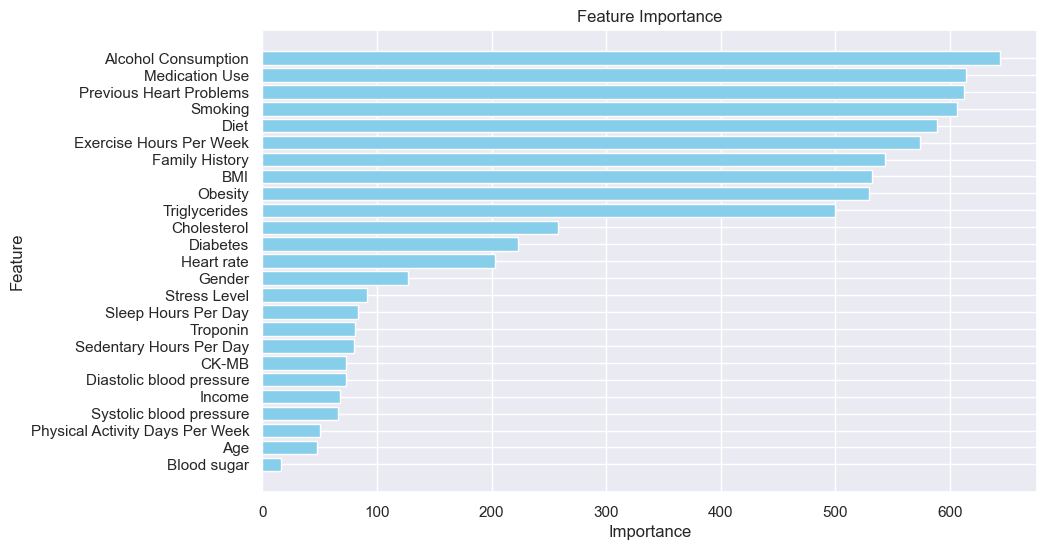

In [1053]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Инвертируем ось Y для лучшего отображения
plt.show()

### Сохранение модели и пайплайна в файл

In [1054]:
joblib.dump(model, MODEL_NAME_PKL)

['models/model_heart_attack.pkl']

In [1055]:
joblib.dump(optuna_lgbm.best_estimator_.named_steps['preprocessor'], 'models/pipeline.pkl')

['models/pipeline.pkl']

### Обучение модели после удаления маловажных признаков

In [1056]:
ohe_columns = [
    'Gender'
]

num_columns = [
    'Cholesterol',
    'Heart rate',
    'Exercise Hours Per Week',
    'BMI',
    'Triglycerides',
    'Blood sugar',
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Diet',
    'Previous Heart Problems',
    'Medication Use'
]

list_of_columns = ohe_columns + num_columns

In [1057]:
# Выполним разделение датафреймов
X_train = train_df[list_of_columns]
y_train = train_df['Heart Attack Risk (Binary)']

X_test = test_df[list_of_columns]

In [1058]:
# Пайплайн для подготовки признаков из списка ohe_columns:
# - заполнение пропусков
# - OHE- кодирование

ohe_pipe = Pipeline(
    [
        ("trans", transformer),
        ('SimpeImputer_ohe', SimpleImputer(missing_values=np.nan, 
                                           strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [1059]:
# Пайплайн для подготовки количественных признаков
num_pipe = Pipeline(
    [
        ('SimpeImputer_num', SimpleImputer(missing_values=np.nan, 
                                           strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [1060]:
# Пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

In [1061]:
# Итоговый пайплайн
final_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

In [1062]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': distributions.CategoricalDistribution([DecisionTreeClassifier(random_state=RANDOM_STATE)]),
        'models__max_depth': distributions.IntDistribution(5, 12),
        'models__max_features': distributions.IntDistribution(5, 12),
        'preprocessor__num__scaler': distributions.CategoricalDistribution(['passthrough'])
    },
    
    # LGBMClassifier
    {
        'models': distributions.CategoricalDistribution([lgb.LGBMClassifier(random_state=RANDOM_STATE)]),
        'models__learning_rate': distributions.CategoricalDistribution([0.001, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5]),
        'models__num_leaves': distributions.CategoricalDistribution([1, 2, 4, 6, 8, 10, 15, 20, 30, 50]),
        'models__n_estimators': distributions.CategoricalDistribution([25, 50, 100, 125, 150]),
        'models__max_depth': distributions.IntDistribution(2, 10),
        'preprocessor__num__scaler': distributions.CategoricalDistribution(['passthrough'])
    },
    

    # словарь для модели LogisticRegression()
    {
        'models': distributions.CategoricalDistribution([LogisticRegression(random_state=RANDOM_STATE, 
                                                              penalty='elasticnet', 
                                                              solver='saga')]),
        'models__l1_ratio': distributions.CategoricalDistribution([0, 0.1, 0.2, 0.3, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'models__C': distributions.IntDistribution(1, 6),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': distributions.CategoricalDistribution([KNeighborsClassifier()]),
        'models__n_neighbors': distributions.IntDistribution(2, 6),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    }
]

optuna_tree = OptunaSearchCV(
        final_pipe,
        param_grid[0],
        cv=5,
        scoring='roc_auc',
        n_trials=15,
        random_state=RANDOM_STATE
    )

optuna_lgbm= OptunaSearchCV(
        final_pipe,
        param_grid[1],
        cv=5,
        scoring='roc_auc',
        n_trials=100,
        random_state=RANDOM_STATE
    )

optuna_logistic = OptunaSearchCV(
        final_pipe,
        param_grid[2],
        cv=5,
        scoring='roc_auc',
        n_trials=1,
        random_state=RANDOM_STATE
    )

optuna_knn = OptunaSearchCV(
        final_pipe,
        param_grid[3],
        cv=5,
        scoring='roc_auc',
        n_trials=10,
        random_state=RANDOM_STATE
    )

In [1063]:
optuna_tree.fit(X_train, y_train)
print()

[I 2025-08-24 18:46:53,840] A new study created in memory with name: no-name-c8d61e24-705b-4c02-a363-55005017eac0
[I 2025-08-24 18:46:54,044] Trial 0 finished with value: 0.5354636358909476 and parameters: {'models': DecisionTreeClassifier(max_depth=8, max_features=11, random_state=42), 'models__max_depth': 8, 'models__max_features': 11, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 0 with value: 0.5354636358909476.
[I 2025-08-24 18:46:54,182] Trial 1 finished with value: 0.5107153157184929 and parameters: {'models': DecisionTreeClassifier(max_depth=5, max_features=7, random_state=42), 'models__max_depth': 5, 'models__max_features': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 0 with value: 0.5354636358909476.
[I 2025-08-24 18:46:54,348] Trial 2 finished with value: 0.5215584836243081 and parameters: {'models': DecisionTreeClassifier(max_depth=8, max_features=7, random_state=42), 'models__max_depth': 8, 'models__max_features': 7, 'preprocessor__num__scaler

In [1064]:
optuna_lgbm.fit(X_train, y_train)
print()

[I 2025-08-24 18:46:56,763] A new study created in memory with name: no-name-cd5f3b6f-7494-4673-b5c8-9036e43657e0
[I 2025-08-24 18:46:56,960] Trial 0 finished with value: 0.5375762838363549 and parameters: {'models': LGBMClassifier(learning_rate=0.05, max_depth=9, n_estimators=25, num_leaves=8,
               random_state=42), 'models__learning_rate': 0.05, 'models__num_leaves': 8, 'models__n_estimators': 25, 'models__max_depth': 9, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 0 with value: 0.5375762838363549.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGB

[I 2025-08-24 18:46:57,361] Trial 1 finished with value: 0.5573378447128927 and parameters: {'models': LGBMClassifier(max_depth=6, n_estimators=125, num_leaves=20, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 20, 'models__n_estimators': 125, 'models__max_depth': 6, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5573378447128927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[I 2025-08-24 18:46:57,532] Trial 2 finished with value: 0.5206953668204998 and parameters: {'models': LGBMClassifier(max_depth=2, n_estimators=25, num_leaves=15, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 15, 'models__n_estimators': 25, 'models__max_depth': 2, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5573378447128927.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-24 18:46:57,720] Trial 3 finished with value: 0.5310575788773578 and parameters: {'models': LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=25, num_leaves=20,
               random_state=42), 'models__learning_rate': 0.05, 'models__num_leaves': 20, 'models__n_estimators': 25, 'models__max_depth': 3, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5573378447128927.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-24 18:46:57,931] Trial 4 finished with value: 0.5396732589559521 and parameters: {'models': LGBMClassifier(max_depth=3, n_estimators=50, num_leaves=30, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 30, 'models__n_estimators': 50, 'models__max_depth': 3, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5573378447128927.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-24 18:46:58,268] Trial 5 finished with value: 0.5550972542118695 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=9, n_estimators=150, num_leaves=10,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 10, 'models__n_estimators': 150, 'models__max_depth': 9, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5573378447128927.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 15
[LightGBM] [Info] [binar

[I 2025-08-24 18:46:58,709] Trial 6 finished with value: 0.5614598000872608 and parameters: {'models': LGBMClassifier(learning_rate=0.3, max_depth=10, n_estimators=150, num_leaves=20,
               random_state=42), 'models__learning_rate': 0.3, 'models__num_leaves': 20, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5614598000872608.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binar

[I 2025-08-24 18:46:58,960] Trial 7 finished with value: 0.5284429702849325 and parameters: {'models': LGBMClassifier(learning_rate=0.001, max_depth=10, n_estimators=50,
               num_leaves=15, random_state=42), 'models__learning_rate': 0.001, 'models__num_leaves': 15, 'models__n_estimators': 50, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5614598000872608.
[W 2025-08-24 18:46:59,061] Trial 8 failed with parameters: {'models': LGBMClassifier(max_depth=10, n_estimators=25, num_leaves=1, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 1, 'models__n_estimators': 25, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:46:59,062] Trial 8 failed with value nan.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 15
[LightGBM] [Info] [binar

[I 2025-08-24 18:46:59,241] Trial 9 finished with value: 0.537355631670923 and parameters: {'models': LGBMClassifier(learning_rate=0.3, max_depth=2, n_estimators=25, num_leaves=20,
               random_state=42), 'models__learning_rate': 0.3, 'models__num_leaves': 20, 'models__n_estimators': 25, 'models__max_depth': 2, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5614598000872608.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-24 18:46:59,468] Trial 10 finished with value: 0.5233305961457377 and parameters: {'models': LGBMClassifier(learning_rate=0.08, max_depth=9, num_leaves=2, random_state=42), 'models__learning_rate': 0.08, 'models__num_leaves': 2, 'models__n_estimators': 100, 'models__max_depth': 9, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5614598000872608.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 15
[LightGBM] [Info] [binar

[I 2025-08-24 18:46:59,782] Trial 11 finished with value: 0.5498081442257755 and parameters: {'models': LGBMClassifier(learning_rate=0.3, max_depth=6, n_estimators=150, num_leaves=6,
               random_state=42), 'models__learning_rate': 0.3, 'models__num_leaves': 6, 'models__n_estimators': 150, 'models__max_depth': 6, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5614598000872608.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 15
[LightGBM] [Info] [binar

[I 2025-08-24 18:47:00,247] Trial 12 finished with value: 0.5710278215699613 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=6, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 6, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-24 18:47:00,749] Trial 13 finished with value: 0.5649704494222216 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-24 18:47:01,243] Trial 14 finished with value: 0.5649704494222216 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing

[I 2025-08-24 18:47:01,621] Trial 15 finished with value: 0.5554206541554777 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=5, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-24 18:47:02,116] Trial 16 finished with value: 0.5649704494222216 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-24 18:47:02,382] Trial 17 finished with value: 0.5442694647061334 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=5, n_estimators=125, num_leaves=4,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 4, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binar

[W 2025-08-24 18:47:02,490] Trial 18 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, num_leaves=1, random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 100, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:02,491] Trial 18 failed with value nan.
[W 2025-08-24 18:47:02,587] Trial 19 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, num_leaves=1, random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 100, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:02,588] Trial 19 failed with value nan.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-24 18:47:03,014] Trial 20 finished with value: 0.5640879806855944 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, num_leaves=50, random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 100, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-08-24 18:47:03,124] Trial 21 failed with parameters: {'models': LGBMClassifier(learning_rate=0.08, max_depth=8, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.08, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:03,124] Trial 21 failed with value nan.
[W 2025-08-24 18:47:03,222] Trial 22 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=8, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:03,222] Trial 22 failed with value nan.
[W 2025-08-24 18:47:03,318] Trial 23 failed with parameters: {'models': LGBM

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-24 18:47:06,472] Trial 51 finished with value: 0.5646963687036486 and parameters: {'models': LGBMClassifier(learning_rate=0.08, max_depth=8, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.08, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.
[W 2025-08-24 18:47:06,580] Trial 52 failed with parameters: {'models': LGBMClassifier(learning_rate=0.001, max_depth=5, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.001, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[W 2025-08-24 18:47:06,581] Trial 52 failed with value nan.
[W 2025-08-24 18:47:06,676] Trial 53 failed with parameters: {'models': LGBMClassifier(learning_rate=0.001, max_depth=5, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.001, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:06,677] Trial 53 failed with value nan.
[W 2025-08-24 18:47:06,771] Trial 54 failed with parameters: {'models': LGBMClassifier(learning_rate=0.001, max_depth=5, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.001, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:06,772] Trial 54 failed with value nan.
[W 2025-08

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binar

[I 2025-08-24 18:47:07,833] Trial 63 finished with value: 0.5505290786658037 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=5, n_estimators=125, num_leaves=6,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 6, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.
[W 2025-08-24 18:47:07,942] Trial 64 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=4, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 4, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:07,943] Trial 64 failed with value nan.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004


[W 2025-08-24 18:47:08,043] Trial 65 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=4, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 4, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:08,043] Trial 65 failed with value nan.
[W 2025-08-24 18:47:08,141] Trial 66 failed with parameters: {'models': LGBMClassifier(learning_rate=0.001, max_depth=4, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.001, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 4, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:08,141] Trial 66 failed with value nan.
[W 2025-08-24 18:47:08,236] Trial 67 failed with parameters: {'models': LG

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binar

[I 2025-08-24 18:47:08,781] Trial 71 finished with value: 0.5228857460739762 and parameters: {'models': LGBMClassifier(learning_rate=0.001, max_depth=4, n_estimators=125, num_leaves=4,
               random_state=42), 'models__learning_rate': 0.001, 'models__num_leaves': 4, 'models__n_estimators': 125, 'models__max_depth': 4, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.
[W 2025-08-24 18:47:08,887] Trial 72 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:08,887] Trial 72 failed with value nan.
[W 2025-08-24 18:47:08,985] Trial 73 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-24 18:47:11,704] Trial 97 finished with value: 0.5649704494222216 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 12 with value: 0.5710278215699613.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[W 2025-08-24 18:47:11,817] Trial 98 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=8, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:11,818] Trial 98 failed with value nan.
[W 2025-08-24 18:47:11,911] Trial 99 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=8, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-24 18:47:11,911] Trial 99 failed with value nan.


[LightGBM] [Info] Number of positive: 3013, number of negative: 5670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 8683, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347000 -> initscore=-0.632253
[LightGBM] [Info] Start training from score -0.632253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [1065]:
optuna_logistic.fit(X_train, y_train)
print()

[I 2025-08-24 18:47:12,001] A new study created in memory with name: no-name-1a5e02e5-0a61-4a26-9fa5-330fff97f1dd
[I 2025-08-24 18:47:12,334] Trial 0 finished with value: 0.5217434398278976 and parameters: {'models': LogisticRegression(C=6, l1_ratio=0.1, penalty='elasticnet', random_state=42,
                   solver='saga'), 'models__l1_ratio': 0.1, 'models__C': 6, 'preprocessor__num__scaler': StandardScaler()}. Best is trial 0 with value: 0.5217434398278976.


In [1066]:
optuna_knn.fit(X_train, y_train)
print()

[I 2025-08-24 18:47:12,411] A new study created in memory with name: no-name-9a8db70c-e1fd-4433-a87d-f21089c8ce45
[I 2025-08-24 18:47:13,771] Trial 0 finished with value: 0.5556997221349876 and parameters: {'models': KNeighborsClassifier(n_neighbors=4), 'models__n_neighbors': 4, 'preprocessor__num__scaler': StandardScaler()}. Best is trial 0 with value: 0.5556997221349876.
[I 2025-08-24 18:47:15,096] Trial 1 finished with value: 0.5556997221349876 and parameters: {'models': KNeighborsClassifier(n_neighbors=4), 'models__n_neighbors': 4, 'preprocessor__num__scaler': StandardScaler()}. Best is trial 0 with value: 0.5556997221349876.
[I 2025-08-24 18:47:15,570] Trial 2 finished with value: 0.5493771671446421 and parameters: {'models': KNeighborsClassifier(n_neighbors=2), 'models__n_neighbors': 2, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 0 with value: 0.5556997221349876.
[I 2025-08-24 18:47:16,084] Trial 3 finished with value: 0.5499918170538399 and parameters: {'models': 

In [1067]:
# Результаты по кросс-валидации для модели DecisionTreeClassifier
tree_model = pd.DataFrame(optuna_tree.cv_results_)
max_tree_model = tree_model["mean_test_score"].max()
print(f'Модель = DecisionTreeRegressor. ROC-AUC кросс-валидации: {round(max_tree_model, 2)}')

# Результаты по кросс-валидации для модели LGBMClassifier
lgbm_model = pd.DataFrame(optuna_lgbm.cv_results_)
max_lgbm_model = lgbm_model["mean_test_score"].max()
print(f'Модель = LGBMClassifier. ROC-AUC кросс-валидации: {round(max_lgbm_model, 2)}')

# Результаты по кросс-валидации для модели LogisticRegression
logistic_model = pd.DataFrame(optuna_logistic.cv_results_)
max_logistic_model = logistic_model["mean_test_score"].max()
print(f'Модель = LogisticRegression. ROC-AUC кросс-валидации: {round(max_logistic_model, 2)}')

# Результаты по кросс-валидации для модели KNeighborsClassifier
knn_model = pd.DataFrame(optuna_knn.cv_results_)
max_knn_model = knn_model["mean_test_score"].max()
print(f'Модель = KNeighborsClassifier. ROC-AUC кросс-валидации: {round(max_knn_model, 2)}')

Модель = DecisionTreeRegressor. ROC-AUC кросс-валидации: 0.55
Модель = LGBMClassifier. ROC-AUC кросс-валидации: 0.57
Модель = LogisticRegression. ROC-AUC кросс-валидации: 0.52
Модель = KNeighborsClassifier. ROC-AUC кросс-валидации: 0.56


Вывод по разделу **"Обучение модели после удаления маловажных признаков"**

Мы решаем сохранить все признаки из датасета, так как удаление менее значимых признаков не привело к улучшению качества прогнозирования.

## Выводы

- Выполнена загрузка данных;
- Выполнена предобработка данных:
    - Выявлены пропуски в данных;
    - Выявлены аномалии в данных в признаке **Gender**
    - Удалены выбросы в признаке **Heart rate**;
    - Дубликаты отсутствуют;
- Выполнен исследовательский анализ данных:
    - Признаки масштабированы;
    - Обнаружены выбросы;
    - Выполнен корреляционный анализ - мультиколениарность не обнаружена
- Выполнено обучение моделей:
    - Выбрана метрика ROC-AUC;
    - Обучены модели LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, LGBMClassifier
    - Лучшая модель - LGBMClassifier с ROC-AUC = 0.59
    - Параметры лучшей модели LGBMClassifier:
        - *learning_rate=0.2,*
        - *max_depth=10,*
        - *n_estimators=150,*
        - *num_leaves=1,*
        - *random_state=42*
    - Выполнено предсказание для тестовых данных и сохранены в файл **predictions.csv**
    - Модель сохранена в файл **models/model_heart_attack.pkl**
    - Пайплайн сохранен в файл **models/pipeline.pkl**
    - Признаки, оказывающие наибольшее влияние:
        - *Alcohol Consumption = 644,*
        - *Medication Use = 614,*
        - *Previous Heart Problems = 612,*
        - *Smoking = 606,*
        - *Diet = 589,*
        - *Exercise Hours Per Week = 574,*
        - *Family History = 543,*
        - *BMI = 532,*
        - *Obesity = 529,*
        - *Triglycerides = 500*
    - Удаление мало значимых признаков не привело к улучшению предсказания